In [91]:
%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from pylab import *
import scipy.stats as st
import statsmodels as sm
import numpy as np
import pandas as pd
from sympy import *
from ipywidgets import FloatProgress
from IPython.display import display
from matplotlib import cm

## Propagation de l'erreur pour n rebonds

On considère deux murs face à face, la balle rebondit entre l'un et l'autre, avec une incertitude $\sigma_{\theta}$ sur sa vitesse initiale. On regarde après n rebonds l'angle qu'a sa vitesse, et on tripatouille.

In [92]:
def f_phys(v,theta,w,e_x,e_y,alpha,R):
    v_x = v*np.sin(theta)
    v_y = -v*np.cos(theta)
    v_x_2 = ((1-alpha*e_x)*v_x + alpha*(1+e_x)*R*w)/(1+alpha)
    v_y_2 = -e_y*v_y
    w_2 = ((1+e_x)*v_x + (alpha-e_x)*R*w)/(R*(1+alpha))
    return [np.sqrt(v_x_2**2 + v_y_2**2), -np.arctan2(v_x_2,v_y_2),w_2]

def makeNRebondsPhys(V,theta,w,e_x,e_y,alpha,R,n,):
    data = np.zeros((n,3))
    data[0,0] = V
    data[0,1] = theta
    data[0,2] = w
    for i in range(1,n):
        r = f_phys(data[i-1,0],-data[i-1,1],-data[i-1,2],e_x,e_y,alpha,R)
        data[i,0] = r[0]
        data[i,1] = r[1]
        data[i,2] = r[2]
    return data

Et si on rajoute de l'incertitude sur theta ?

<IPython.core.display.Javascript object>


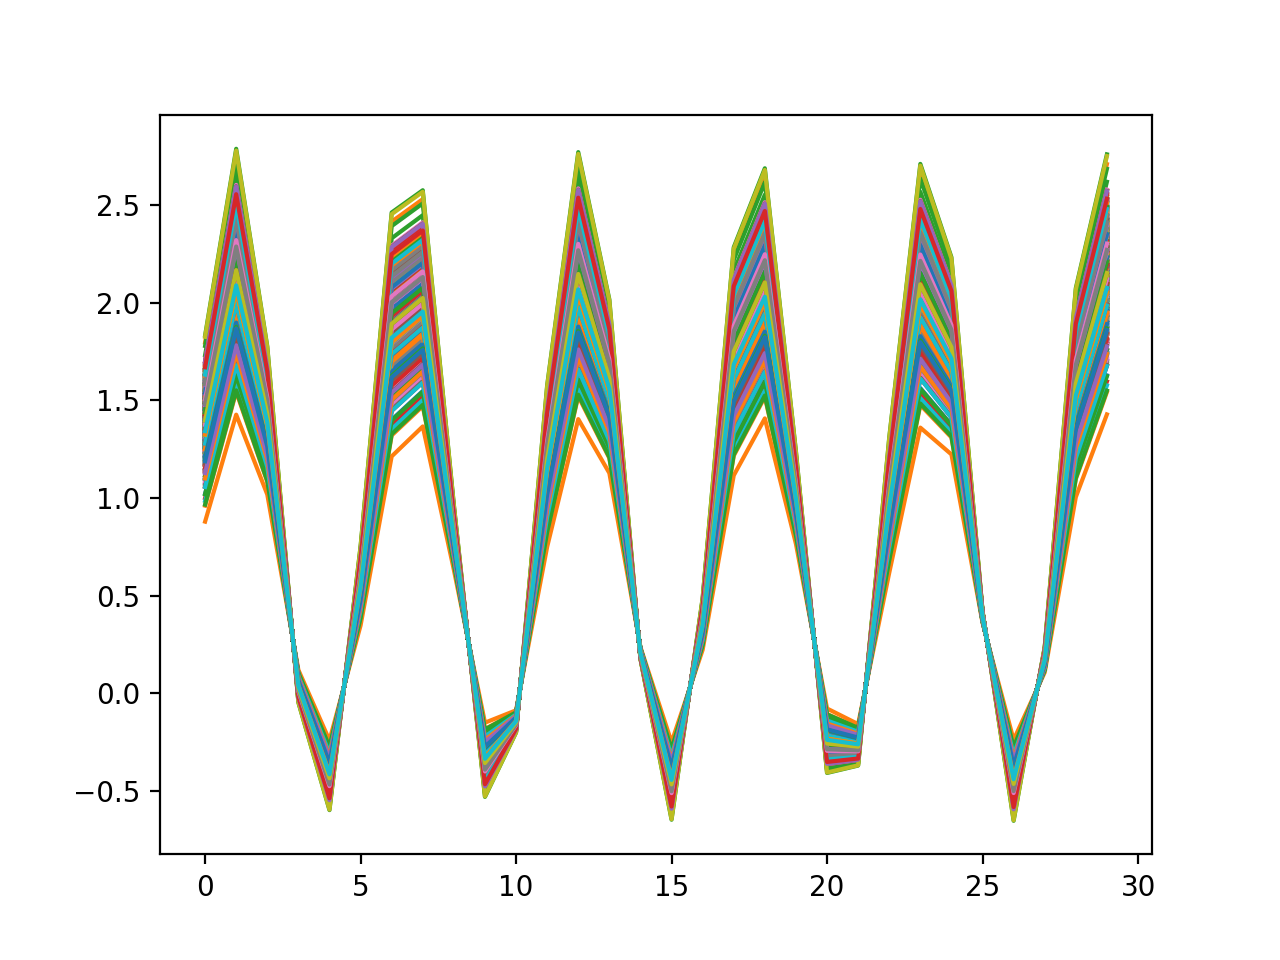

In [97]:
n_samples = 1000
n_rebonds = 30
theta = np.pi/4
sigma_theta = 0.1
rapport = np.zeros((n_samples,n_rebonds))
positions = np.zeros((n_samples,n_rebonds))
plt.figure()
for i in range(n_samples):
    rebonds = makeNRebondsPhys(2,np.random.normal(theta,sigma_theta),6.,1.,1.,0.4,0.05,n_rebonds)
    positions[i,:] = np.cumsum(rebonds[:,0]*np.sin(rebonds[:,1]))
    plt.plot(positions[i,:])

We observe that variance varies much depending on bounces.

This function gives us the position and the energies, with the possibility to introduce noise on the initial conditions.

In [98]:
def horizontal_distrib(V_moy,theta_moy,w_moy, sigma,n_max,e_x,n_samples = 100,alpha=0.4):
    e_y = 1.
    R = 0.05
    largeur = 1.
    x_s = np.zeros((n_samples,n_max))
    E_t = np.zeros((n_samples,n_max))
    E_r = np.zeros((n_samples,n_max))
    for i in range(n_samples):
        theta = np.random.normal(theta_moy, sigma)
        V = V_moy*np.random.normal(1,sigma)
        w = w_moy*np.random.normal(1,sigma)
        dt = largeur/(V*np.cos(theta))
        data = makeNRebondsPhys(V,theta,w,e_x,e_y,alpha,R,n_max)
        x_s[i,:] = dt*np.cumsum(data[:,0]*np.sin(data[:,1]))
        E_t[i,:] = (data[:,0]*np.sin(data[:,1]))**2
        E_r[i,:] = alpha*(data[:,2]*R)**2
    return x_s,E_t,E_r

here we studuy the time of first return

<IPython.core.display.Javascript object>


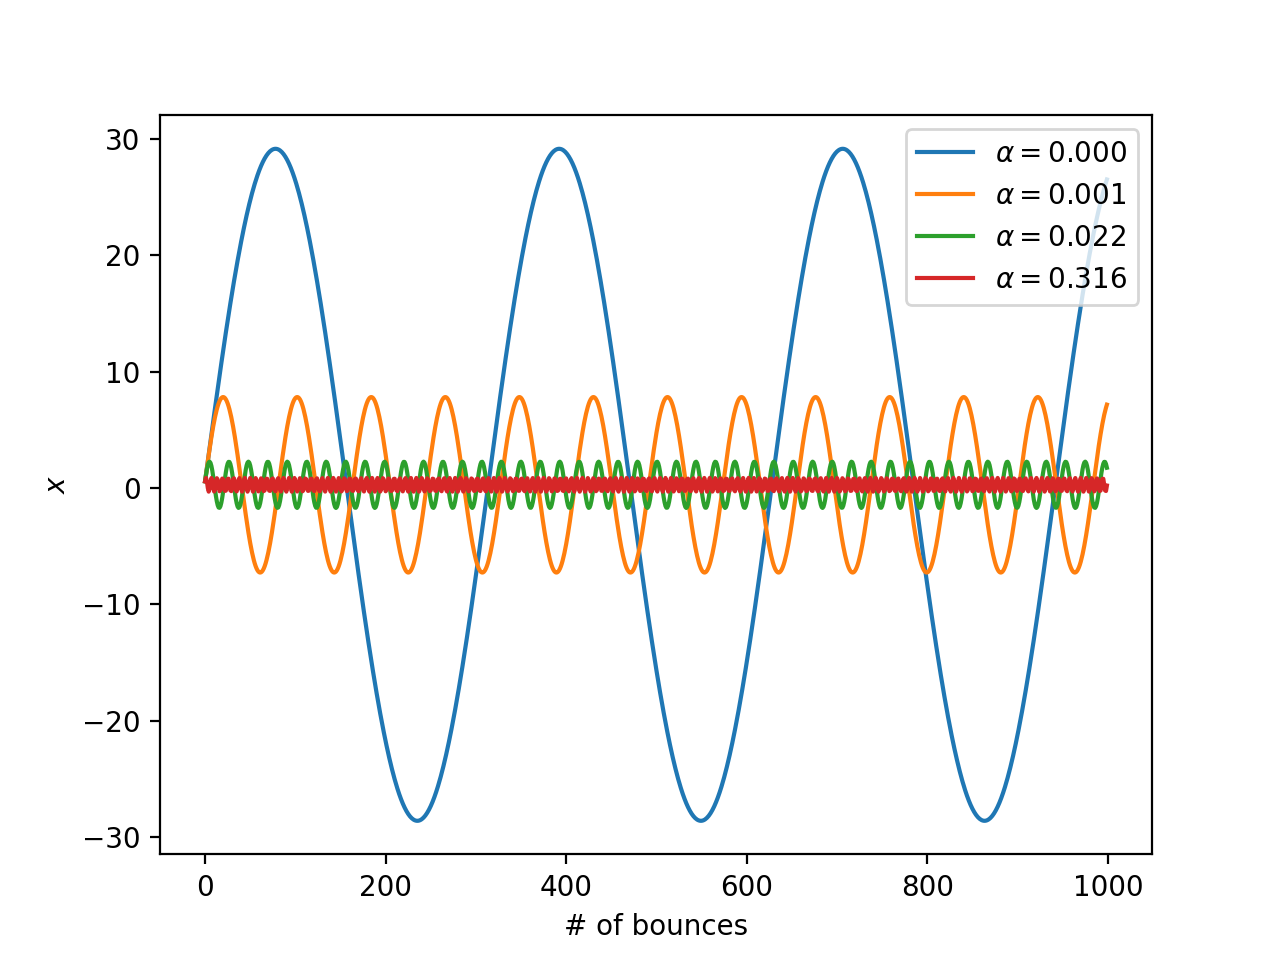

<IPython.core.display.Javascript object>


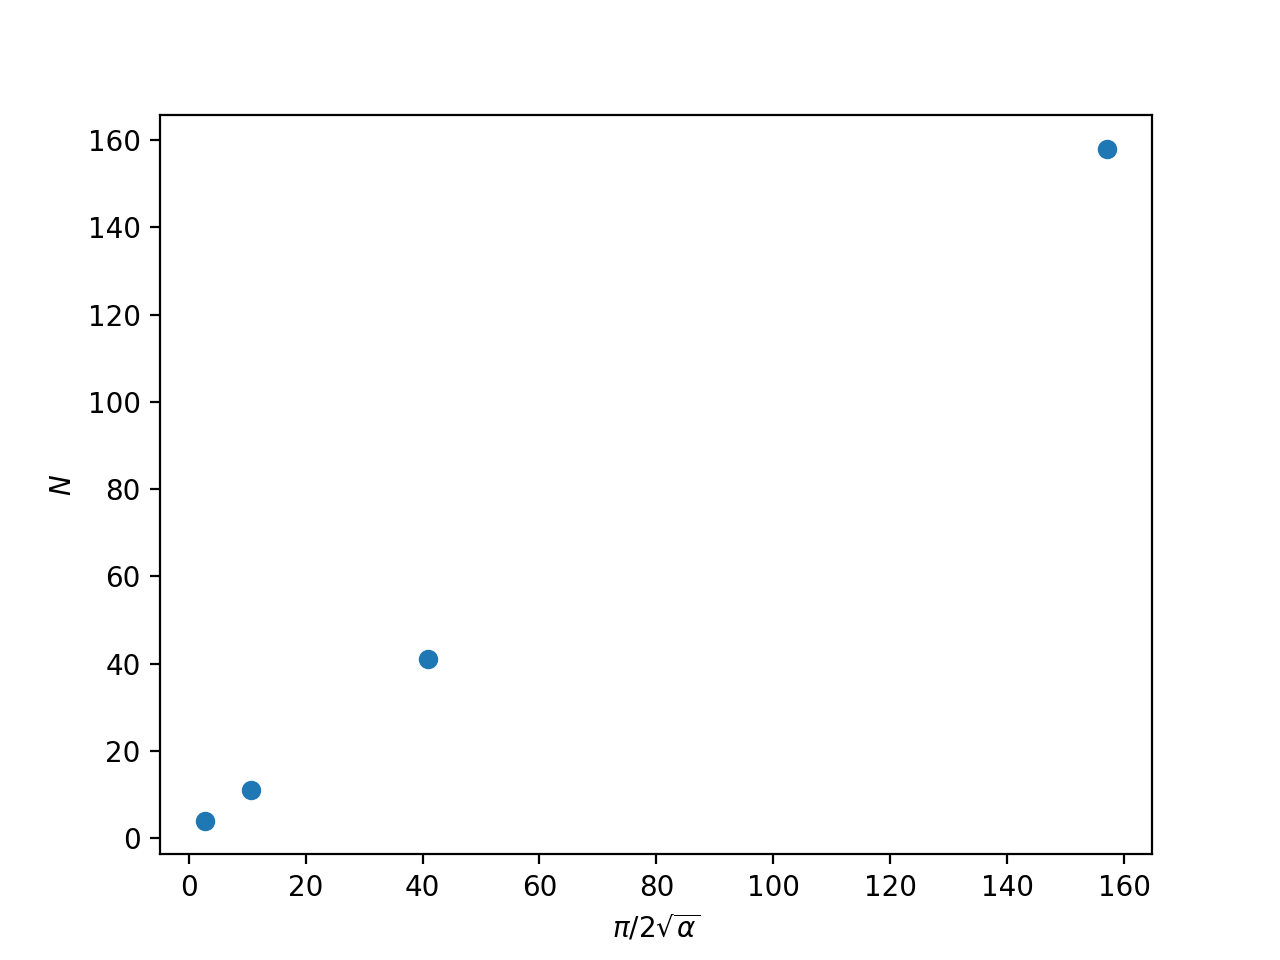

In [99]:
n_rebonds = 1000
n_alphas = 4
x_s = np.zeros((n_alphas,n_rebonds))
alphas = np.logspace(-4,-0.5,n_alphas)

fig = plt.figure()
ax = fig.add_subplot(111)

for i in range(n_alphas):
    x_s[i,:] = horizontal_distrib(10,np.pi/6,-4, 0.,n_rebonds,1.,n_samples=1,alpha=alphas[i])[0]
    ax.plot(x_s[i,:],label="$\\alpha=%.3f$" % alphas[i])
ax.set_xlabel("# of bounces")
ax.set_ylabel("$x$")
ax.legend()
plt.show()

Ns = np.zeros(n_alphas)
for i in range(n_alphas):
    for j in range(n_rebonds):
        if x_s[i,j] < 0 and Ns[i] == 0:
            Ns[i] = j

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(0.5*np.pi/np.sqrt(alphas[:]),Ns[:])
ax.set_xlabel("$\pi/2\sqrt{\\alpha}$")
ax.set_ylabel("$N$")

### Energy repartition as a function of $x$

<IPython.core.display.Javascript object>


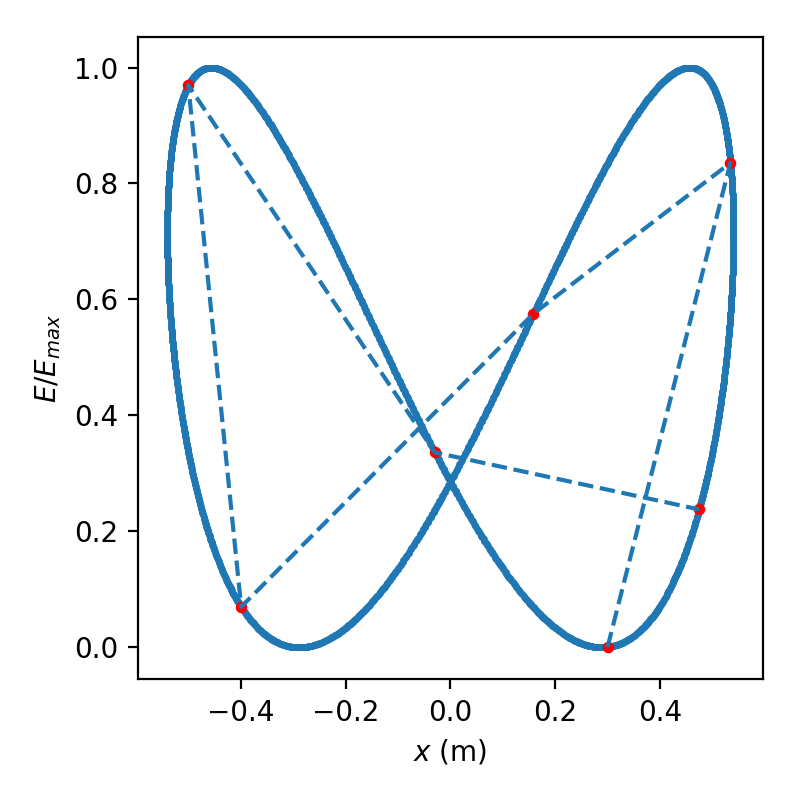

In [100]:
n_rebonds = 3000
x_s,E_t,E_r = horizontal_distrib(10,np.pi/6,-4, 0.,n_rebonds,1.,n_samples=1,alpha=0.4)
x_s.reshape(-1)
E_t.reshape(-1)
E_r.reshape(-1)
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)
#ax.set_title("$\\alpha = 0.4$")
#ax.scatter(np.roll(x_s[0,:],-1)[:-1] - np.mean(x_s),E_t[0,:-1],label="Translation Energy",s=1)
ax.scatter(np.roll(x_s[0,:],0)[:-1] - np.mean(x_s),E_r[0,:-1]/np.max(E_r[0,:-1]),label="Rotation Energy",s=2)
#ax.scatter(np.roll(x_s[0,:8],-1) - np.mean(x_s),E_t[0,:8],s=1)
ax.scatter(np.roll(x_s[0,:8],0)[:-1] - np.mean(x_s),E_r[0,:7]/np.max(E_r[0,:-1]),s=10,color='red')
#ax.plot(np.roll(x_s[0,1:8],-1) - np.mean(x_s),E_t[0,1:8])
ax.plot(np.roll(x_s[0,0:8],0)[:-1] - np.mean(x_s),E_r[0,:7]/np.max(E_r[0,:-1]),'--')
ax.set_xlabel("$x$ (m)")
ax.set_ylabel("$E/E_{max}$")
plt.tight_layout()
#ax.legend()

### Study of the influence of $e_x$

<IPython.core.display.Javascript object>


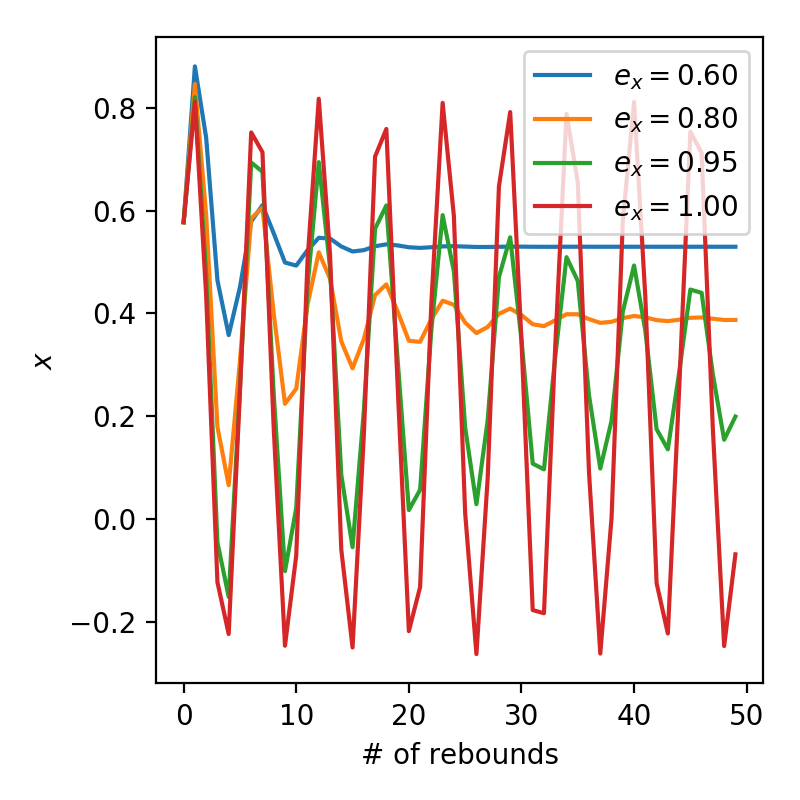

<IPython.core.display.Javascript object>


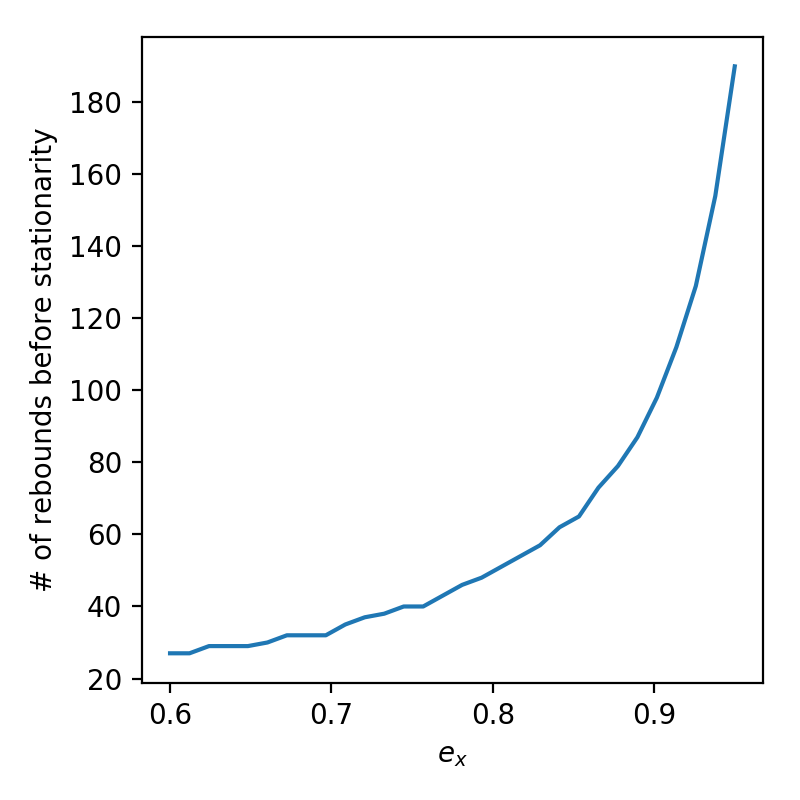

<IPython.core.display.Javascript object>


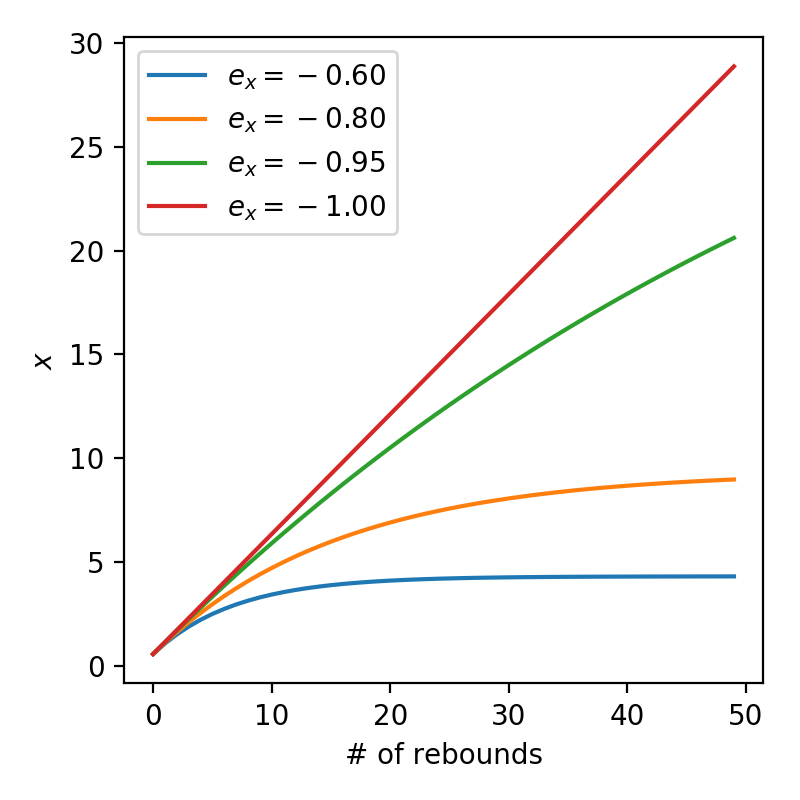

<IPython.core.display.Javascript object>


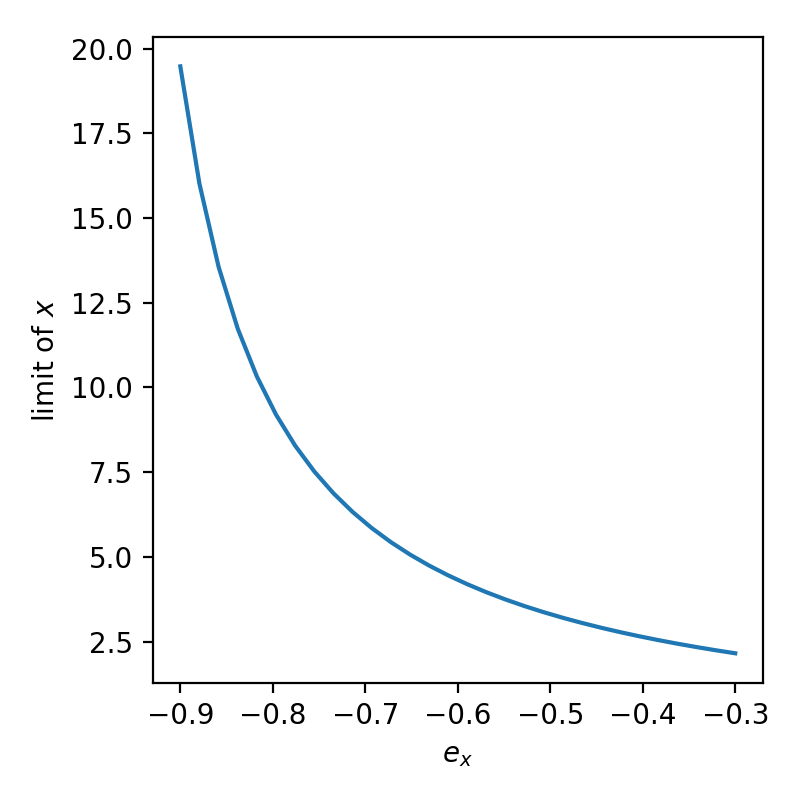

In [101]:
fig = plt.figure(figsize=(4,4))

ax = fig.add_subplot(111)

for e_x in [0.6, 0.8, 0.95,1]:
    x_s = np.reshape(horizontal_distrib(10,np.pi/6,-4, 0.,50,e_x,n_samples=1)[0],-1)
    ax.set_xlabel("# of rebounds")
    ax.set_ylabel("$x$")
    ax.plot(x_s[:],label="$e_x = %.2f$" % (e_x))
ax.legend()
plt.tight_layout()

fig = plt.figure(figsize=(4,4))

ax = fig.add_subplot(111)

window_size = 10
n_ex = 30
exs = np.linspace(0.6,0.95,n_ex)
n_critic = np.zeros(n_ex)
i = 0
for e_x in exs:
    x_s = np.reshape(horizontal_distrib(10,np.pi/6,-4, 0.,1000,e_x,n_samples=1)[0],-1)
    for j in range(window_size,1000):
        if np.max(x_s[j-window_size:j]) - np.min(x_s[j-window_size:j]) < 0.01:
            n_critic[i] = j
            break
    i += 1
ax.set_xlabel("$e_x$")
ax.set_ylabel("# of rebounds before stationarity")
ax.plot(exs, n_critic)
ax.legend()
plt.tight_layout()

fig = plt.figure(figsize=(4,4))

ax = fig.add_subplot(111)
for e_x in [-0.6, -0.8, -0.95,-1.]:
    x_s = np.reshape(horizontal_distrib(10,np.pi/6,-4, 0.,50,e_x,n_samples=1)[0],-1)
    ax.set_xlabel("# of rebounds")
    ax.set_ylabel("$x$")
    ax.plot(x_s[:],label="$e_x = %.2f$" % (e_x))

ax.legend()    
plt.tight_layout()

def lim_x(v,theta,w,n_max,e_x):
    x_s = np.reshape(horizontal_distrib(v,theta,w, 0.,n_max,e_x,n_samples=1)[0],-1)
    if e_x < 0:
        if np.abs(np.max(x_s)) > np.abs(np.min(x_s)):
            return np.max(x_s)
        else:
            return np.min(x_s)
    if e_x >= 0:
        return 0
    
exs = np.linspace(-.9,-0.3,n_ex)
limites = np.zeros(n_ex)
for i in range(n_ex):
    limites[i] = lim_x(10,np.pi/6,-4,1000,exs[i])

fig = plt.figure(figsize=(4,4))
    
ax = fig.add_subplot(111)
ax.plot(exs, limites)
ax.set_xlabel("$e_x$")
ax.set_ylabel("limit of $x$")
fig.tight_layout()


In [142]:
#This signifies : "Hit wall at d"
#In this cell there are several functions used to study the propability density functions of the height
#of the ball at a given distance d from its initial position

def taperMuraD(dist, V_moy,theta_moy,w_moy, sigma,e_x,e_y=1.,sigma_e=0.00,n_samples = 10000):
    alpha = 0.4
    R = 0.05
    largeur = 1.
    hs = np.zeros(n_samples)
    ns = np.zeros(n_samples)
    xs = []
    ys = []
    for i in range(n_samples):
        theta = np.random.normal(theta_moy, sigma*np.pi)
        V = V_moy*np.random.normal(1,sigma)
        w = w_moy*np.random.normal(1,sigma)
        n = 0
        dt = largeur/(V*np.cos(theta))
        distance = dt*V*np.sin(theta) # The ball is launched at equal distance from both walls
        xs.append(0)
        ys.append(largeur)
        xs.append(distance)
        ys.append(0)
        while(distance < dist and n < 30):
            r = f_phys(V,theta,w,np.random.normal(e_x,sigma_e),1.,alpha,R)
            V = r[0]
            theta = -r[1]
            w = -r[2]
            distance = distance + dt*(V*np.sin(theta))
            if n %2 == 0:
                ys.append(largeur)
            else:
                ys.append(0)
            xs.append(distance)
            n += 1
        if n < 30 and n > 0:
            y = dist - (distance-dt*V*np.sin(theta))
            x = distance - dist
            if n % 2 == 1:
                hs[i] = largeur*y/(x+y)
            else:
                hs[i] = largeur*x/(x+y)

            xs[-1] = dist
            ys[-1] = hs[i]
        elif n == 0:
            hs[i] = largeur-dt*V*np.cos(theta)*(dist/distance)
        else:
            hs[i] = -1.
        
        ns[i] = -1
    return hs,ns,xs,ys

def quantify_info(distrib):
    bins, hist = np.histogram(distrib, normed=True,bins=100,range=[0.,1.])
    return st.entropy(bins)/np.log(len(hist) - 1)

#Ici on ajoute du bruit sur les composantes sensorielles
def plot_distribs():
    e_x = -0.8
    v = 10.
    theta = np.pi/6
    w = -4
    i = 1
    for x in [0.7,0.8,0.9,3.]:
        fig = plt.figure(figsize=(4,4))
        ax = fig.add_subplot(111)
        hs = taperMuraD(x, v,theta,w, 0.010,e_x)[0]
        hs2 = taperMuraD(x, v,theta,w, 0.005,e_x)[0]
        hs3 = taperMuraD(x, v,theta,w, 0.002,e_x)[0]
        hs4 = taperMuraD(x, v,theta,w, 0.001,e_x)[0]
        ax.hist(hs,bins=50, normed=True,alpha=0.5,range=[0.,1.])
        ax.hist(hs2,bins=50, normed=True,alpha=0.5,range=[0.,1.])
        ax.hist(hs3,bins=50, normed=True,alpha=0.5,range=[0.,1.])
        ax.hist(hs4,bins=50, normed=True,alpha=0.5,range=[0.,1.])
        ax.set_xlabel("$h/L$ at $d/L = %.2f$" % (x))
        i = i + 1
        plt.tight_layout()
    study_info(plt.figure(figsize=(4,4)), e_x, v, theta, w)
    

def study_info(fig, e_x, v, theta, w):
    n_x = 50
    x_s = np.linspace(0.1,2.,n_x)
    n_sigmas = 4
    e_y = 1.

    sigmas = np.logspace(-3.,-2.,n_sigmas)
    info = np.zeros((n_x,n_sigmas))
    hs = np.zeros((n_x,n_sigmas,10000))
    for i in range(n_x):
        for j in range(n_sigmas):
            hs[i,j,:] = taperMuraD(x_s[i], v,theta,w, sigmas[::-1][j],e_x,e_y,sigma_e=0.,n_samples=10000)[0]
            #print hs[i,j,:]
            info[i,j] = quantify_info(hs[i,j,:])
    ax = fig.add_subplot(111)
    for j in range(n_sigmas):
        ax.plot(x_s,info[:,j], label="$\sigma = %.3f$" % (sigmas[::-1][j]))
    ax.set_ylabel("Normalized entropy")
    ax.set_xlabel("$d/L$")
    ax.legend()
    plt.tight_layout()

def entropy_for_speed(e_x,fixed_v,fixed_theta,d=1):
    #It takes too much time to compute the entropy for n_p**3 values
    n_p = 60
    entropy_fixed_v = np.zeros((n_p,n_p))
    entropy_fixed_theta = np.zeros((n_p,n_p))
    vs = np.linspace(1,10,n_p)
    thetas = np.linspace(0.1, np.pi/2 - 0.1,n_p)
    ws = np.linspace(-200,200,n_p)
    f = FloatProgress(min=0, max=n_p**2)
    display(f)
    for i in range(n_p):
        for j in range(n_p):
            f.value += 1
            if lim_x(fixed_v, thetas[i],ws[j],1000,e_x) > d*2:            
                hs = taperMuraD(d, fixed_v, thetas[i],ws[j], 0.002,e_x)[0]
                entropy_fixed_v[i,j] = quantify_info(hs)
            if lim_x(vs[i], fixed_theta,ws[j],1000,e_x) > d*2:            
                hs = taperMuraD(d,vs[i], fixed_theta,ws[j], 0.002,e_x)[0]
                entropy_fixed_theta[i,j] = quantify_info(hs)
    return entropy_fixed_v,entropy_fixed_theta

def plot_trajectories(initial_params, dist,sigma_e = 0.):
    
    alpha = 0.4
    
    fig = plt.figure(figsize=(4,4))
    fig2 = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111)
    ax2 = fig2.add_subplot(111)

    i = 0
    for params in initial_params:
        
        V = params[0]
        theta = params[1]
        omega = params[2]
        e_x = params[3]
        
        E_c = (V*np.sin(theta))**2 + alpha*(R*omega)**2
        E_f = (V*np.cos(theta))**2
        
        r = taperMuraD(dist, V,theta,omega, 0.,e_x,e_y=1.,sigma_e=sigma_e,n_samples=1)
        xs = np.array(r[2])
        ys = np.array(r[3])
        if i == 0:
            ax.plot(xs,ys,color="red")
        else:
            ax.plot(xs,ys,color="orange")
        angles_apres = np.array([np.arctan((xs[i+1] - xs[i])/(ys[i+1] - ys[i])) for i in range(1,len(xs)-1)])
        vitesses_apres = np.array([xs[i+1] - xs[i] for i in range(1,len(xs)-1)])
        angles_avant = np.array([np.arctan((xs[i] - xs[i-1])/(ys[i] - ys[i-1])) for i in range(1,len(xs))])
        #ax2.scatter(xs[1:-1],angles_apres,s=1,label="angles apres")
        #ax2.scatter(xs[1:],angles_avant,s=1,label="angles avant")
        ax2.hist(vitesses_apres)
        
        ax2.legend()
        ax2.plot([-1,1],[np.arctan(np.sqrt(E_c/E_f)),np.arctan(np.sqrt(E_c/E_f))])
        ax2.plot([-1,1],[-np.arctan(np.sqrt(E_c/E_f)),-np.arctan(np.sqrt(E_c/E_f))])
        i = i+ 1
        
    ax.set_xlabel("$x (m)$")
    ax.set_ylabel("$y/L$")
    plt.tight_layout()
     

<IPython.core.display.Javascript object>


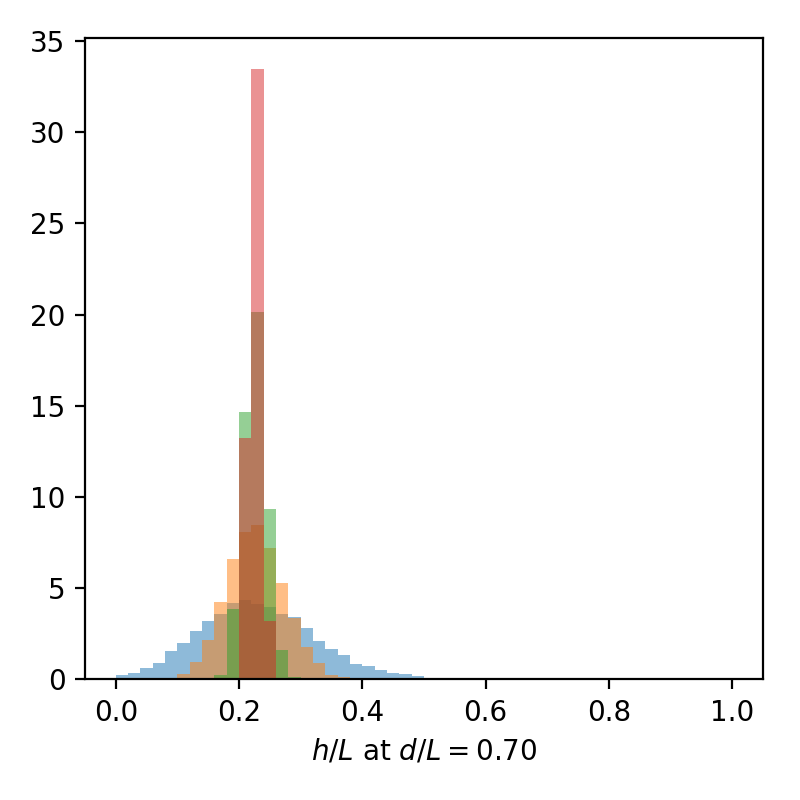

<IPython.core.display.Javascript object>


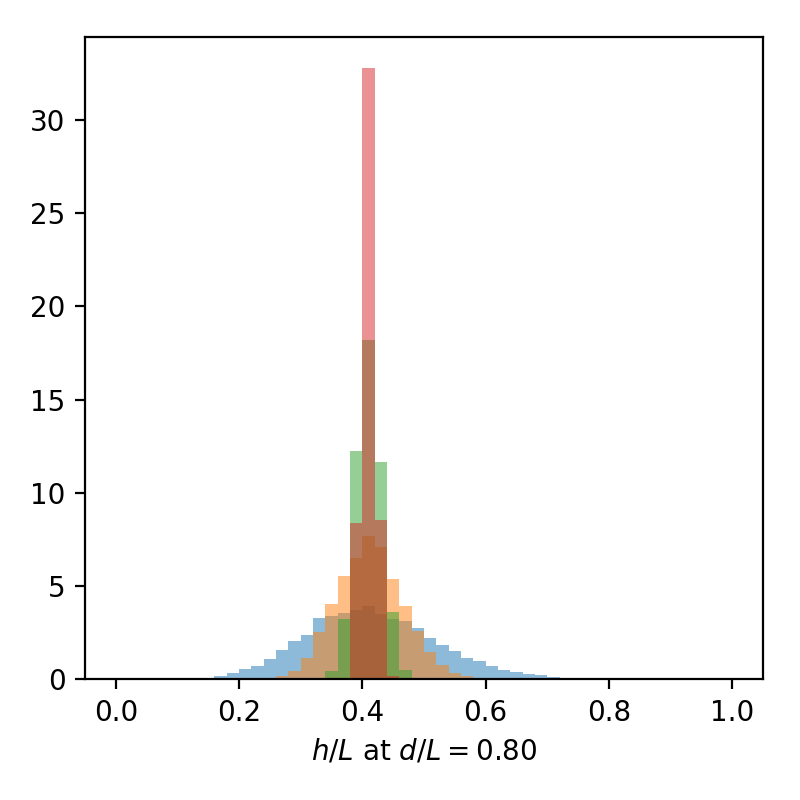

<IPython.core.display.Javascript object>


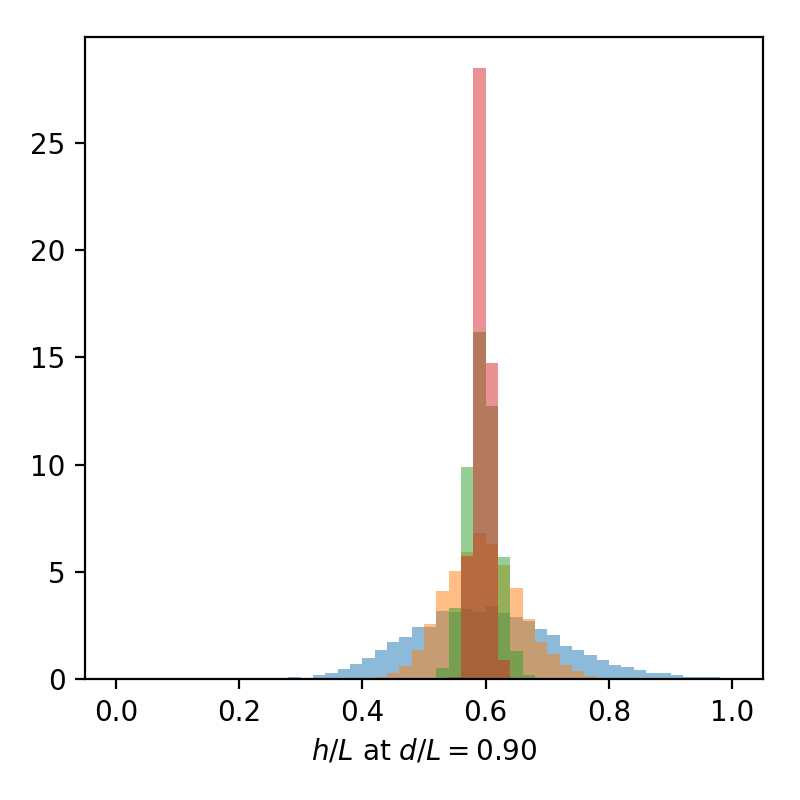

<IPython.core.display.Javascript object>


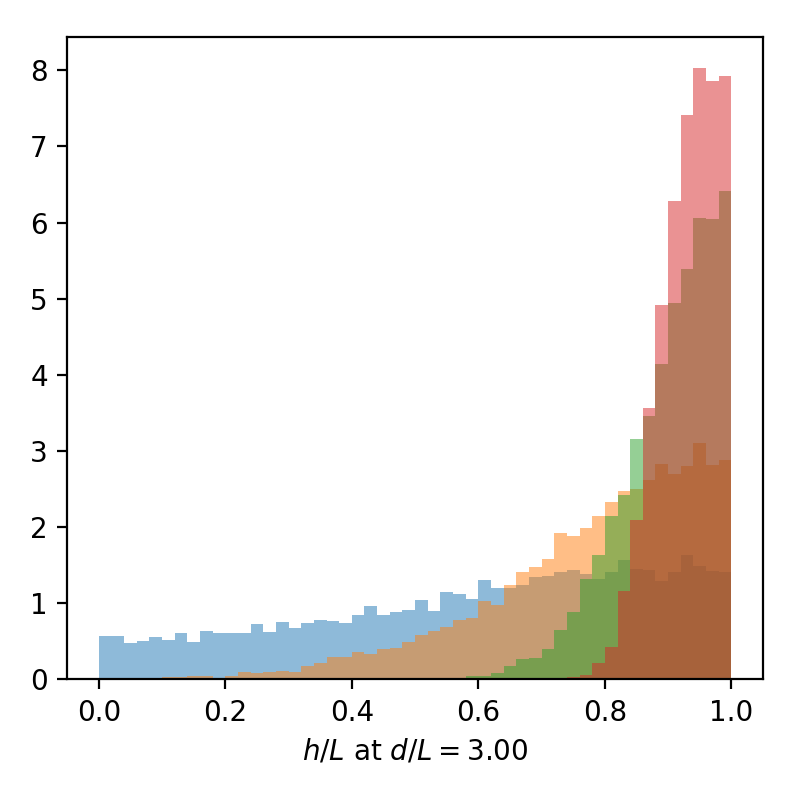

<IPython.core.display.Javascript object>


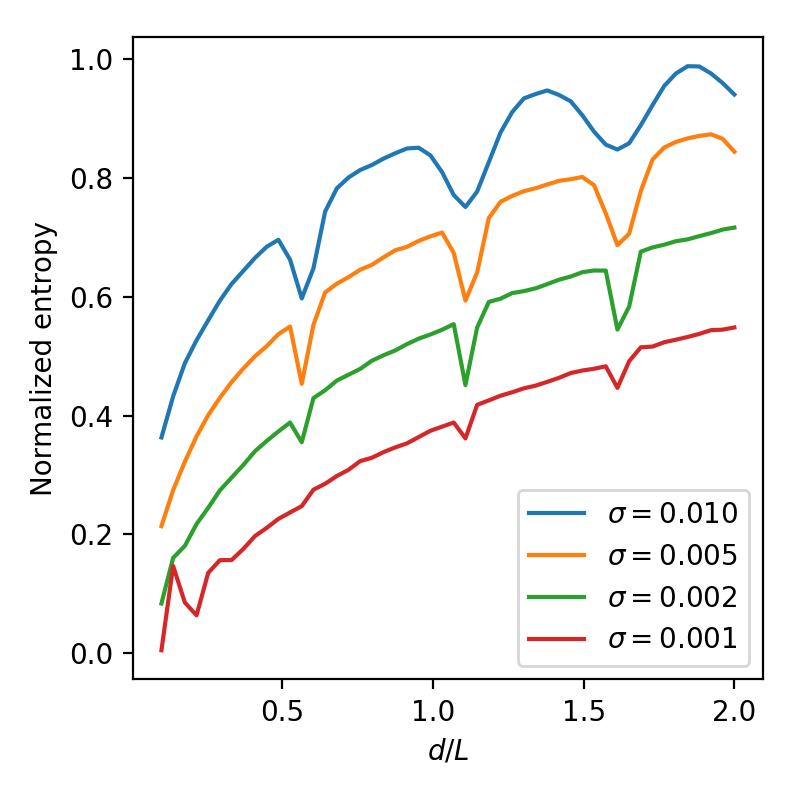

In [132]:
plot_distribs()

In [ ]:
v = 2.
theta = np.pi/6
S = entropy_for_speed(-0.8,v,theta)

<IPython.core.display.Javascript object>


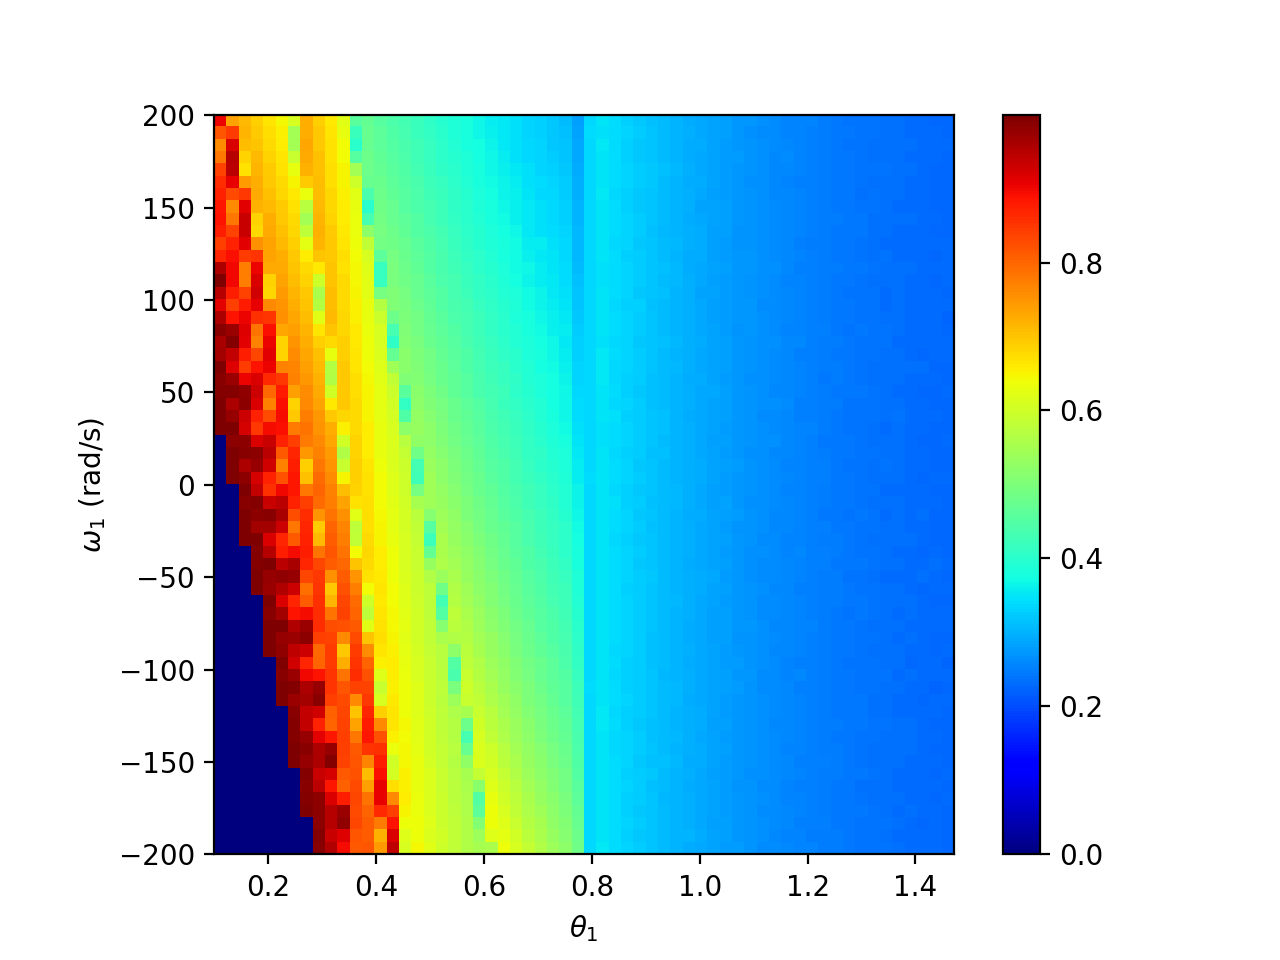

<IPython.core.display.Javascript object>


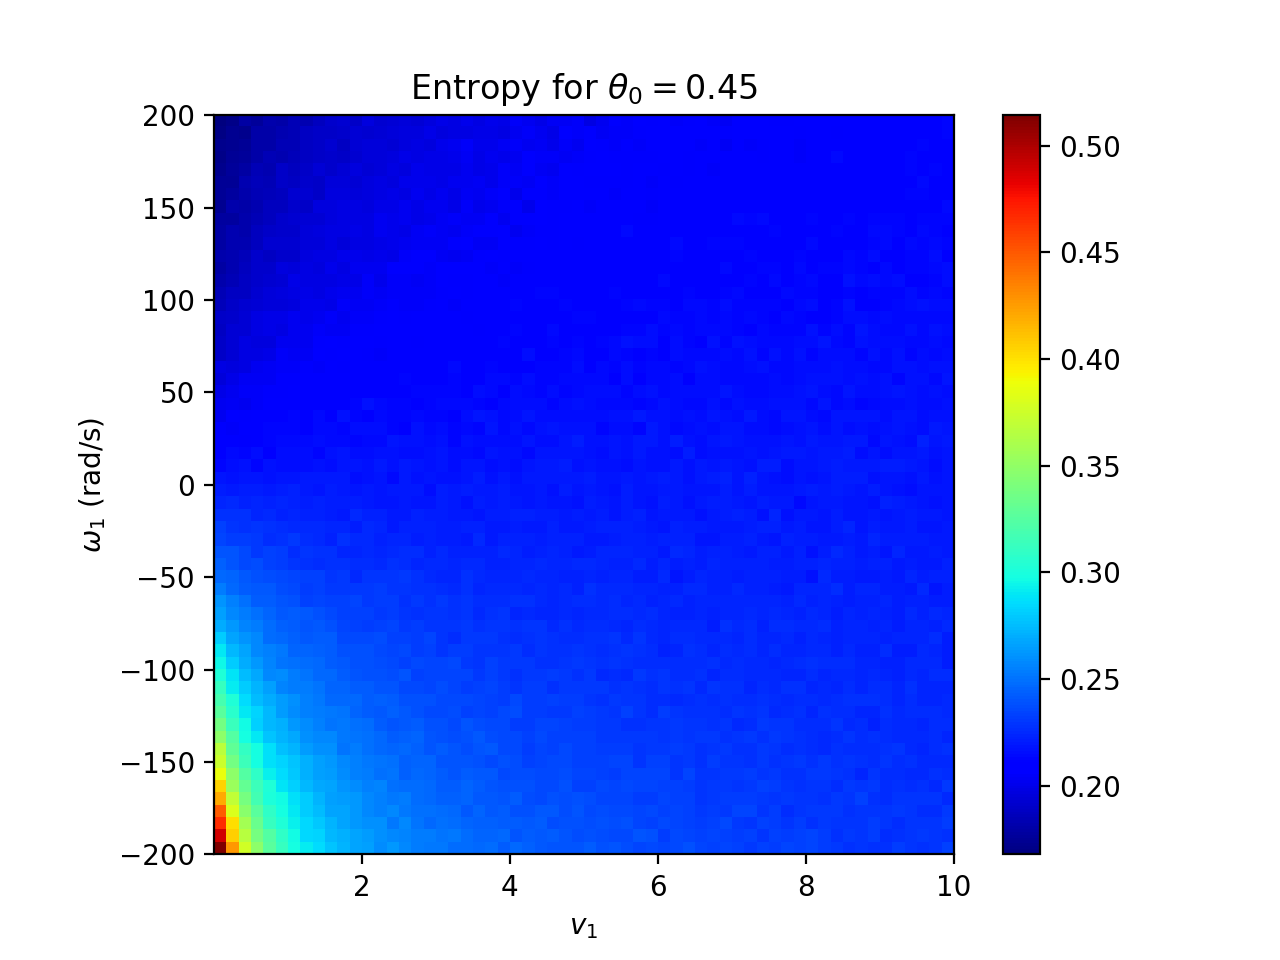

In [145]:
fig = plt.figure()
colors = [(cm.jet(i)) for i in xrange(256)]
new_map = matplotlib.colors.LinearSegmentedColormap.from_list('new_map', colors, N=256)
thetas = np.linspace(0.1, np.pi/2 - 0.1,60)

ax = fig.add_subplot(111)
im = plot_heatmap(ax, S[0][:,:],thetas,omegas,"$\\theta_1$","$\omega_1$ (rad/s)",new_map)
#ax.set_title("Entropy for $v_0 = %.2f$ m/s" % (vs[15]))
#cbar_ax = fig.add_axes([0.903, 0.15, 0.03, 0.7])
plt.colorbar(im)

fig = plt.figure()
ax = fig.add_subplot(111)
im = plot_heatmap(ax, S[1][:,:],vs,omegas,"$v_1$","$\omega_1$ (rad/s)",new_map)
ax.set_title("Entropy for $\\theta_0 = %.2f$" % (thetas[15]))
#cbar_ax = fig.add_axes([0.903, 0.15, 0.03, 0.7])
plt.colorbar(im)

### Plotting trajectories

<IPython.core.display.Javascript object>


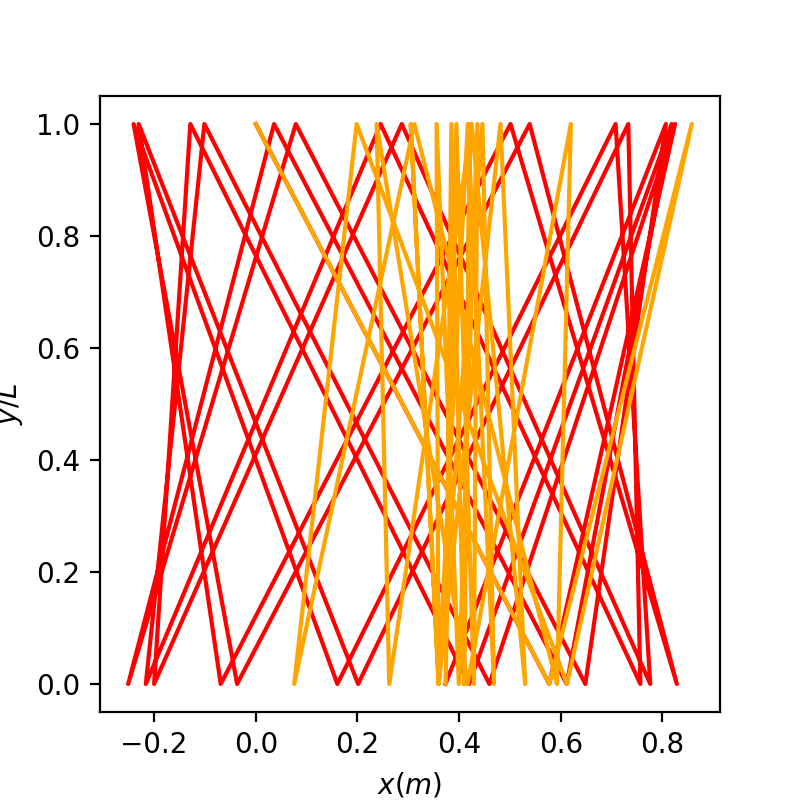

<IPython.core.display.Javascript object>


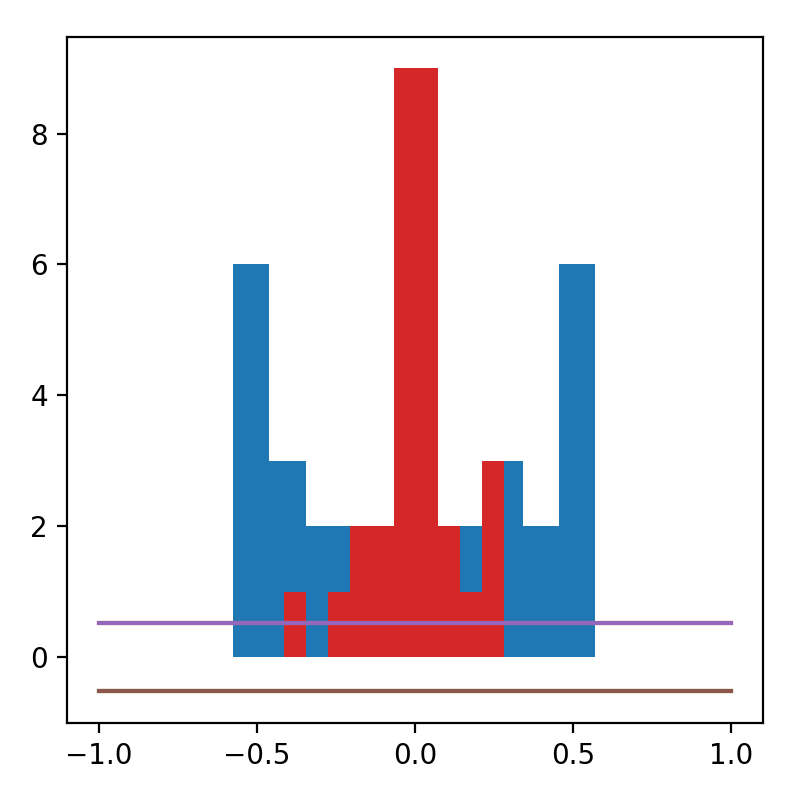

In [35]:
plot_trajectories([[1,np.pi/6,0.,1.],[1,np.pi/6,0.,0.8]], 1.)

Et si on regardait la distribution de l'$E_c$ de translation (avec $e_x = e_y = 1$) ?

### How does amplitude vary as a function of the initial conditions ?

<IPython.core.display.Javascript object>


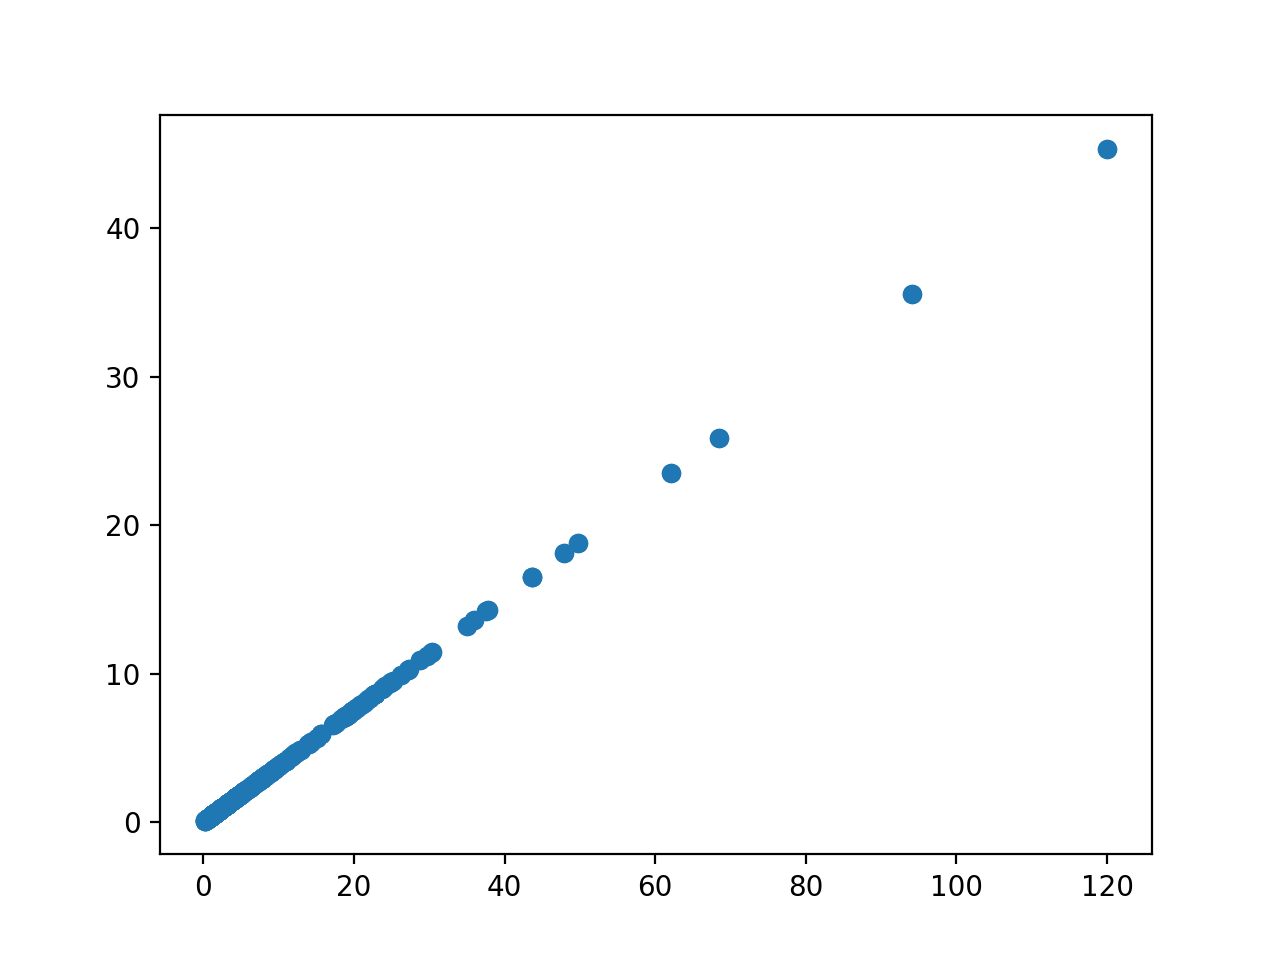

In [265]:
dist = 1000
n_v = 10
Vs = np.linspace(0.5,5,n_v)
thetas = np.linspace(0.1,np.pi/2-0.1,n_v)
omegas = np.linspace(-100,100,n_v)

amplitudes = np.zeros((n_v,n_v,n_v))
delta_t_sqrt_E_h = np.zeros((n_v,n_v,n_v))

for i in range(n_v):
    for j in range(n_v):
        for k in range(n_v):
            x = np.array(taperMuraD(dist, Vs[i],thetas[j],omegas[k], 0.,e_x,e_y=1.,sigma_e=0.00,n_samples=1)[2])
            amplitudes[i,j,k] = np.max(x) - np.min(x)
            delta_t_sqrt_E_h[i,j,k] = np.sqrt(0.5*(Vs[i]*np.sin(thetas[j]))**2 + 0.5*alpha*(R*omegas[k])**2)/(Vs[i]*np.cos(thetas[j]))

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(np.reshape(amplitudes[:,:,:],-1), np.reshape(delta_t_sqrt_E_h[:,:,:],-1))

### What if we add noise in $e_x$ ?

<IPython.core.display.Javascript object>


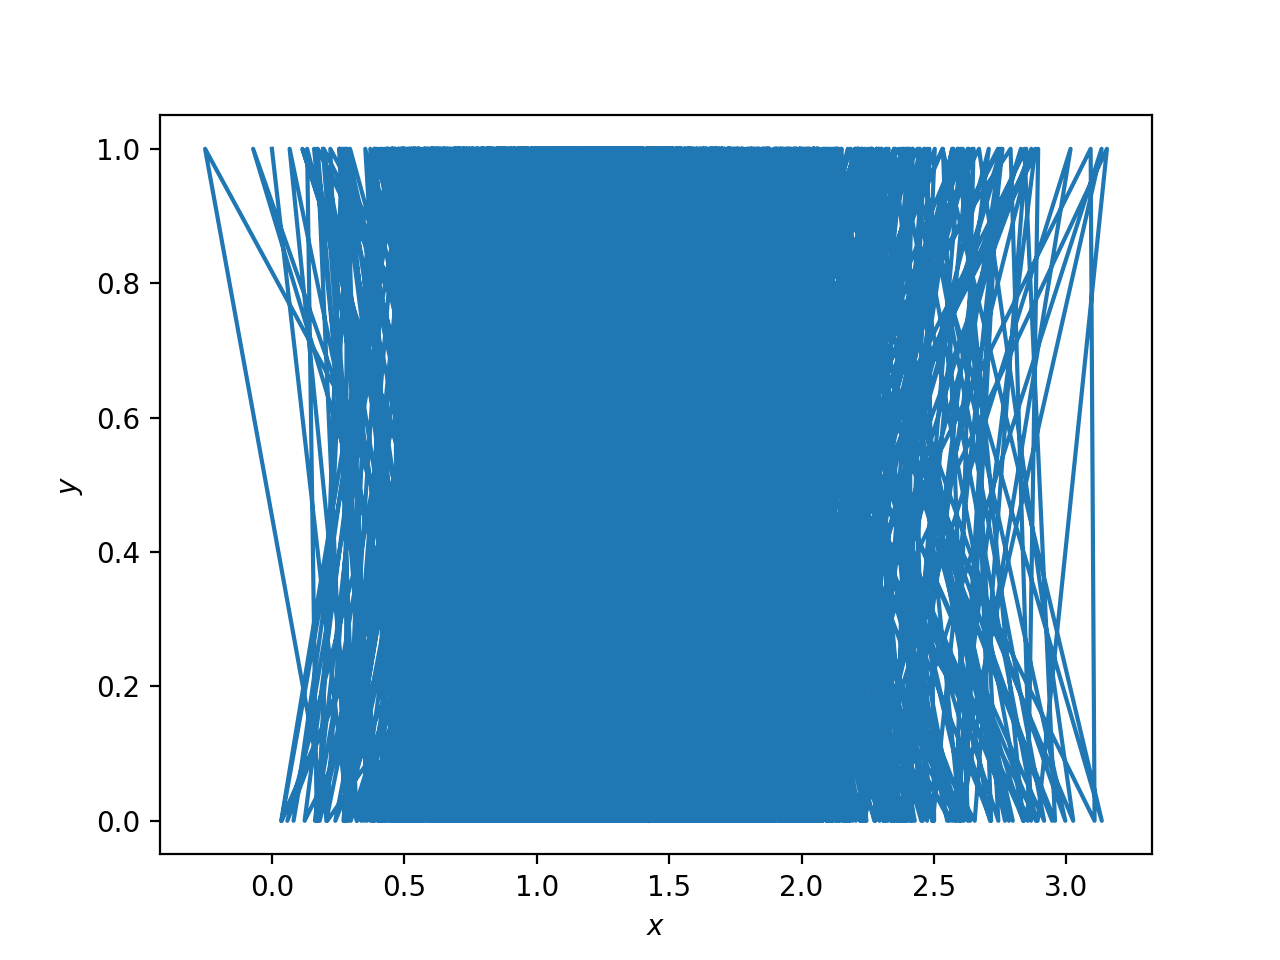

<IPython.core.display.Javascript object>


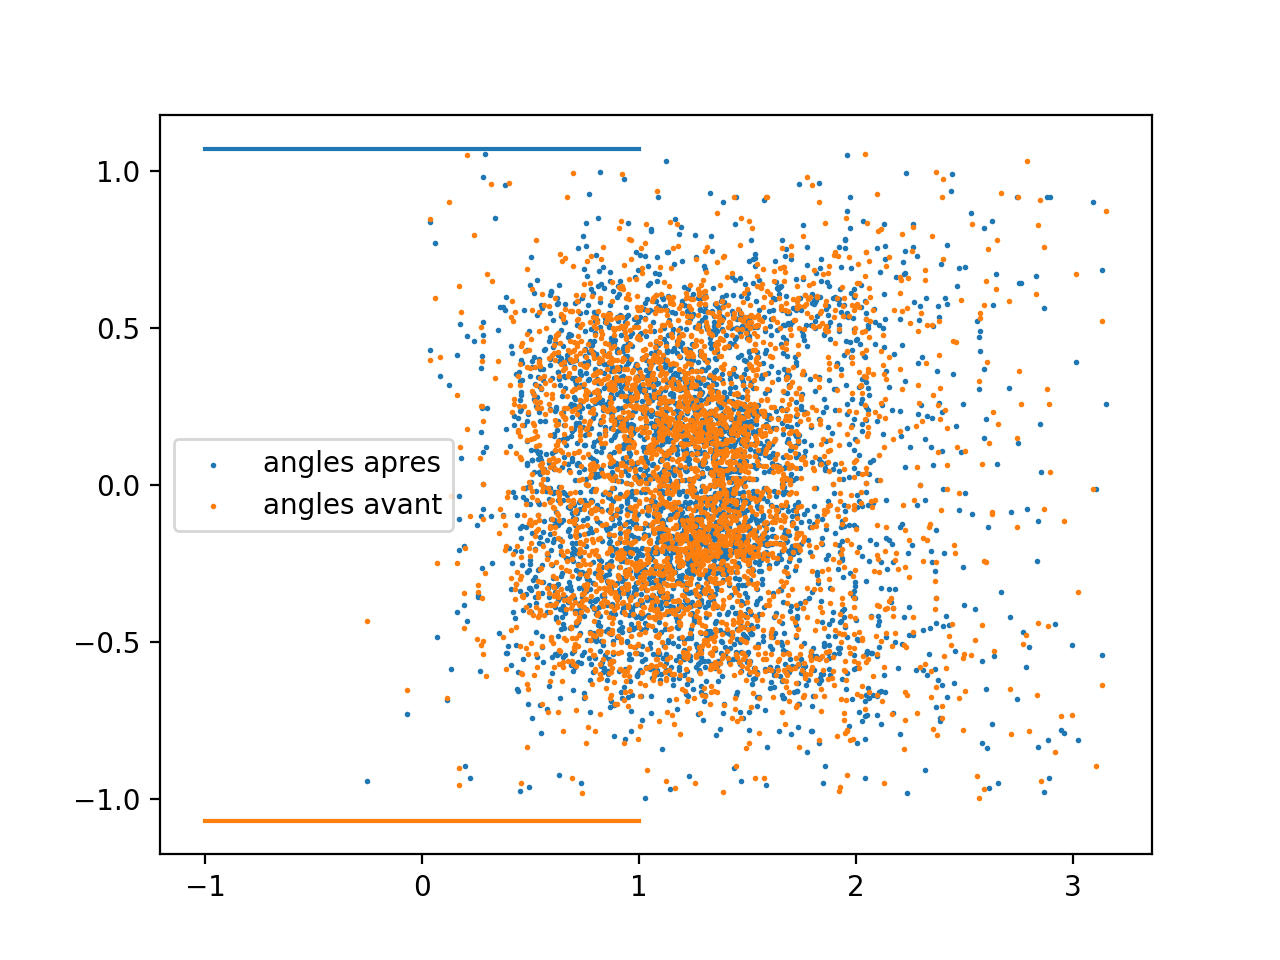

In [332]:
phi = np.pi/3
plot_trajectories([[r*np.cos(phi)/np.cos(np.pi/6),np.pi/6,r*np.sin(phi)/(np.sqrt(alpha)*R)] for r in [1.]], 1.,10.,sigma_e=0.05)

### Just a small function to plot heatmaps easily

<IPython.core.display.Javascript object>


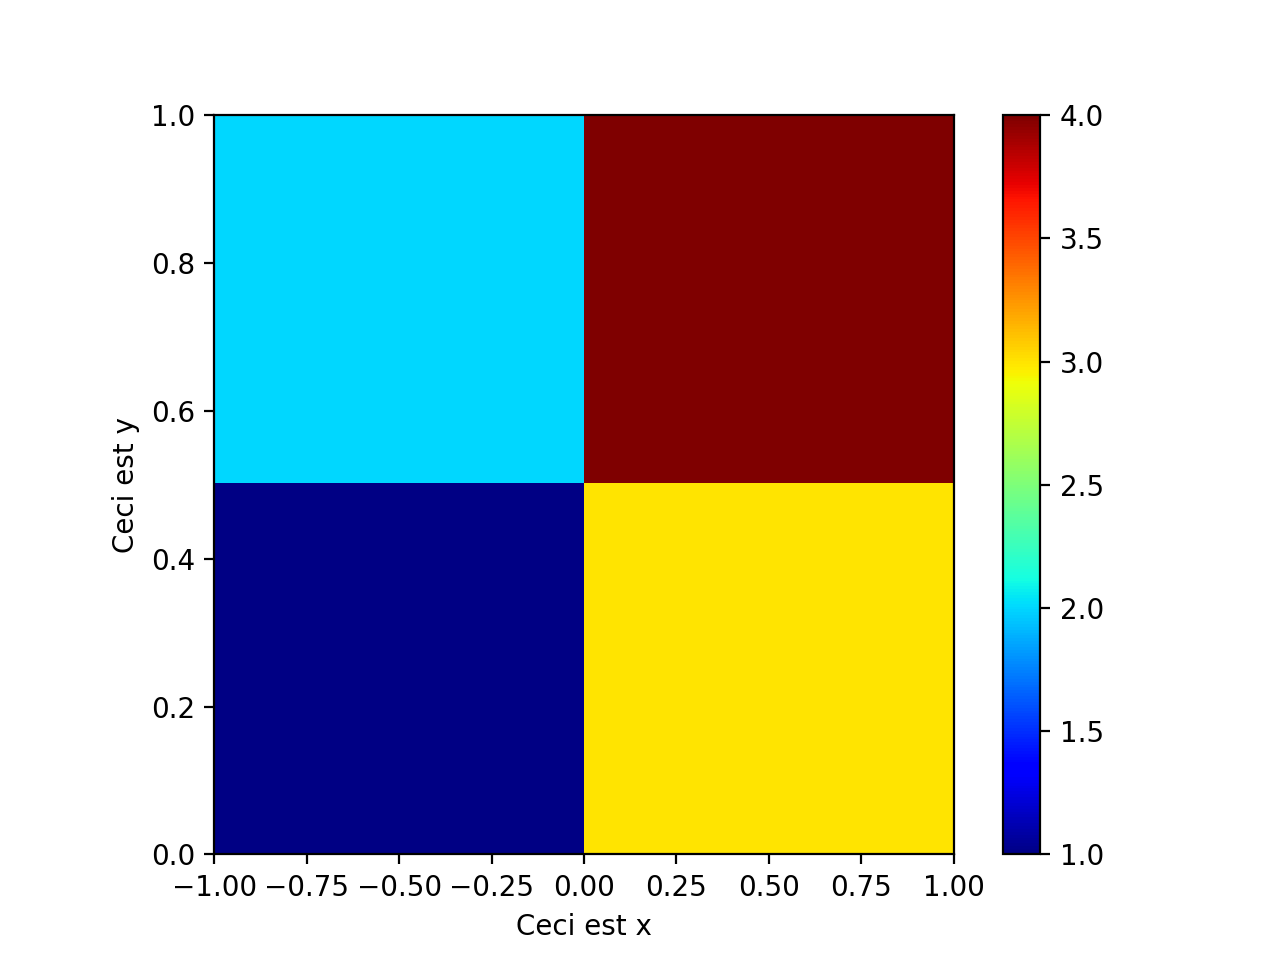

In [51]:
def plot_heatmap(ax,data,x,y,x_label,y_label,cmap,vmin=0,vmax=0):
    #ax is 2-dimensional. Its first dimension is x (horizontal), the second is y (vertical).
    #x and y arguments are the ranges corresponding to each direction
    if vmin == 0 and vmax == 0:
        vmin = np.min(data)
        vmax = np.max(data)
    asp = (np.min(x)-np.max(x))/(np.min(y)-np.max(y))
    im = ax.imshow(np.transpose(data)[::-1,:],cmap=cmap,extent=[np.min(x),np.max(x),np.min(y),np.max(y)],aspect=asp,vmin=vmin,vmax=vmax)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    return im
  
colors = [(cm.jet(i)) for i in xrange(1,256)]
new_map = matplotlib.colors.LinearSegmentedColormap.from_list('new_map', colors, N=256)
    
# This is a test    

data = np.zeros((2,2))
data[0,0] = 1
data[0,1] = 2
data[1,0] = 3
data[1,1] = 4
x = [-1,1]
y = [0,1]
    
fig = plt.figure()
ax = fig.add_subplot(111)
im = plot_heatmap(ax, data,x,y,"Ceci est x","Ceci est y",new_map)
plt.colorbar(im)

## Error Propagation through a single collision

In [276]:
size = 50
n_samples = 100
errors_dim_single = np.zeros((size,size,size,3))

e_x = 1.
e_y = 1.
alpha = 0.4
amplitude = 10
R = 0.05
thetas = np.linspace(0.1,np.pi/2 - 0.1,size)
vs = np.linspace(0.01,amplitude,size)
omegas = np.linspace(-np.max(vs)/R,np.max(vs)/R,size)
vec_angle_from_cos_sin = np.vectorize(np.arctan2)
f = FloatProgress(min=0, max=size**3)
display(f)
for i, V in zip(range(size),vs):
    for j, theta in zip(range(size),thetas):
        for k, w in zip(range(size),omegas):
            output_dim = np.zeros((n_samples,3))
            for l in range(n_samples):
                t_r = np.clip(np.random.normal(theta,np.pi/10),0.001,np.pi/2 - 0.001)
                v_r = V*np.random.normal(1,0.1)
                w_r = w*np.random.normal(1,0.1)
                results_dim = f_phys(v_r,t_r,w_r,e_x,e_y,alpha,R)
                output_dim[l,0] = results_dim[0]
                output_dim[l,1] = results_dim[1]
                output_dim[l,2] = results_dim[2]
            f.value += 1
            errors_dim_single[i,j,k,2] = (np.std(output_dim[:,2])/np.abs(np.mean(output_dim[:,2])))/0.1
            errors_dim_single[i,j,k,0] = (np.std(output_dim[:,0])/np.abs(np.mean(output_dim[:,0])))/0.1
            errors_dim_single[i,j,k,1] = np.std(output_dim[:,1])/(0.1*np.pi)

We should use dimensionless parameters : $V = v/\sqrt{gR}$ and $\Omega = \omega/\sqrt{g/R}$

We plot heatmaps which show how noise propagate through a single collision

/Users/Hippolyte/anaconda/lib/python2.7/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


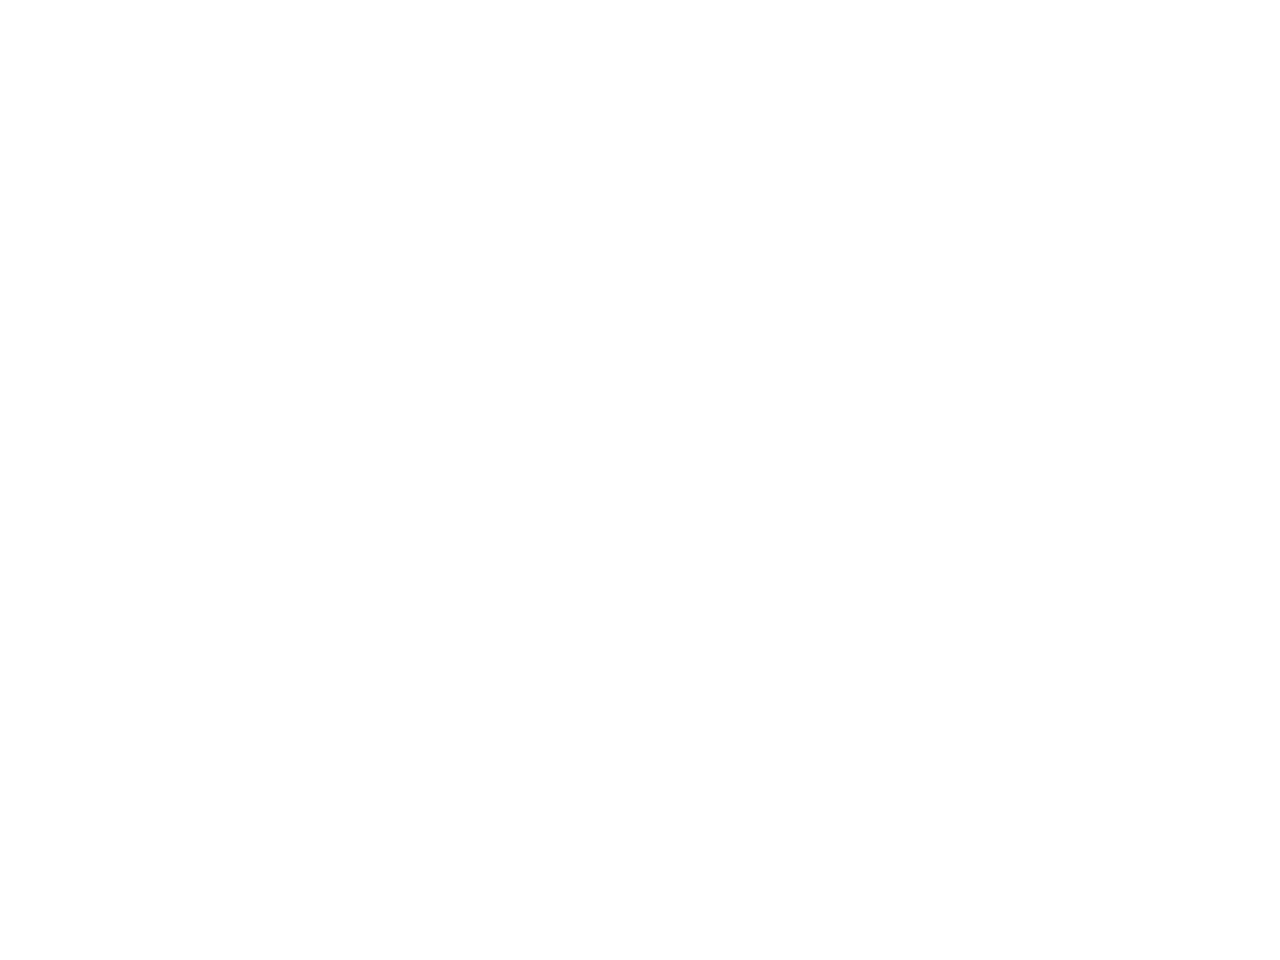

NameError: name 'errors_dim_single' is not defined

In [90]:
colors = [(cm.jet(i)) for i in xrange(256)]
new_map = matplotlib.colors.LinearSegmentedColormap.from_list('new_map', colors, N=256)

size = 50
thetas = np.linspace(0.1,np.pi/2 - 0.1,size)
vs = np.linspace(0.01,amplitude,size)
omegas = np.linspace(-np.max(vs)/R,np.max(vs)/R,size)

fig = plt.figure()
#fig.suptitle("$\log(\\nu_{v_2})$")
vmin = np.min(np.log(np.abs(errors_dim_single[:,:,:,0])))
vmax = np.max(np.log(np.abs(errors_dim_single[:,:,:,0])))
ax = fig.add_subplot(221)
im = plot_heatmap(ax, np.log(errors_dim_single[:,12,:,0]),vs,omegas,"$v_1$ (m/s) $\\theta_1 = %.2f$ rad" % (thetas[12]),"$\omega_1$ (rad/s)",new_map,vmin=vmin,vmax=vmax)
ax = fig.add_subplot(222)
im = plot_heatmap(ax, np.log(errors_dim_single[:,28,:,0]),vs,omegas,"$v_1$ (m/s) $\\theta_1 = %.2f$ rad" % (thetas[28]),"$\omega_1$ (rad/s)",new_map,vmin=vmin,vmax=vmax)
ax = fig.add_subplot(223)
im = plot_heatmap(ax, np.log(errors_dim_single[:,43,:,0]),vs,omegas,"$v_1$ (m/s) $\\theta_1 = %.2f$ rad" % (thetas[12]),"$\omega_1$ (rad/s)",new_map,vmin=vmin,vmax=vmax)
ax = fig.add_subplot(224)
im = plot_heatmap(ax, np.log(errors_dim_single[:,49,:,0]),vs,omegas,"$v_1$ (m/s) $\\theta_1 = %.2f$ rad" % (thetas[12]),"$\omega_1$ (rad/s)",new_map,vmin=vmin,vmax=vmax)
#fig.subplots_adjust(right=0.8)
fig.tight_layout()
cbar_ax = fig.add_axes([0.92, 0.15, 0.03, 0.7])
fig.colorbar(im, cax=cbar_ax)

fig = plt.figure()
#fig.suptitle("$\log(\Delta \\theta_2)$")
vmin = np.min(np.log(np.abs(errors_dim_single[:,:,:,1])))
vmax = np.max(np.log(np.abs(errors_dim_single[:,:,:,1])))
ax = fig.add_subplot(221)
im = plot_heatmap(ax, np.log(errors_dim_single[1,:,:,1]),thetas,omegas,"$\\theta_1$ (rad) $v_1 = %.2f$ m/s" % (vs[1]),"$\omega_1$ (rad/s)",new_map,vmin=vmin,vmax=vmax)
ax = fig.add_subplot(222)
im = plot_heatmap(ax, np.log(errors_dim_single[5,:,:,1]),thetas,omegas,"$\\theta_1$ (rad) $v_1 = %.2f$ m/s" % (vs[5]),"$\omega_1$ (rad/s)",new_map,vmin=vmin,vmax=vmax)
ax = fig.add_subplot(223)
im = plot_heatmap(ax, np.log(errors_dim_single[12,:,:,1]),thetas,omegas,"$\\theta_1$ (rad) $v_1 = %.2f$ m/s" % (vs[12]),"$\omega_1$ (rad/s)",new_map,vmin=vmin,vmax=vmax)
ax = fig.add_subplot(224)
im = plot_heatmap(ax, np.log(errors_dim_single[35,:,:,1]),thetas,omegas,"$\\theta_1$ (rad) $v_1 = %.2f$ m/s" % (vs[35]),"$\omega_1$ (rad/s)",new_map,vmin=vmin,vmax=vmax)
#fig.subplots_adjust(right=0.8)
fig.tight_layout()
cbar_ax = fig.add_axes([0.92, 0.15, 0.03, 0.7])
fig.colorbar(im, cax=cbar_ax)

fig = plt.figure()
#fig.suptitle("$\log(\\nu_{\omega_2})$")
vmin = np.min(np.log(np.abs(errors_dim_single[:,:,:,2])))
vmax = np.max(np.log(np.abs(errors_dim_single[:,:,:,2])))
print "vmin = ", vmin
aspect_theta_v = (np.max(thetas) - np.min(thetas))/(np.max(vs)-np.min(vs))
aspect_w_v = (np.max(omegas) - np.min(omegas))/(np.max(vs)-np.min(vs))
ax = fig.add_subplot(221)
im = plot_heatmap(ax, np.log(np.abs(errors_dim_single[:,:,30,2])),vs,thetas,"$v$ (m/s) $\omega_1 = %.2f$ rad/s" % (omegas[30]),"$\\theta_1$",new_map,vmin=vmin,vmax=vmax)
ax = fig.add_subplot(222)
im = plot_heatmap(ax, np.log(np.abs(errors_dim_single[:,:,40,2])),vs,thetas,"$v$ (m/s) $\omega_1 = %.2f$ rad/s" % (omegas[40]),"$\\theta_1$",new_map,vmin=vmin,vmax=vmax)
ax = fig.add_subplot(223)
im = plot_heatmap(ax, np.log(np.abs(errors_dim_single[:,2,:,2])),vs,omegas,"$v$ (m/s) $\\theta_1 = %.2f$" % (thetas[2]),"$\omega_1$",new_map,vmin=vmin,vmax=vmax)
ax = fig.add_subplot(224)
im = plot_heatmap(ax, np.log(np.abs(errors_dim_single[:,22,:,2])),vs,omegas,"$v$ (m/s) $\\theta_1 = %.2f$" % (thetas[22]),"$\omega_1$",new_map,vmin=vmin,vmax=vmax)
fig.tight_layout()
cbar_ax = fig.add_axes([0.92, 0.15, 0.03, 0.7])
fig.colorbar(im, cax=cbar_ax)

## The Corner Scenario

In [52]:
def rebondCoin(v,theta,omega,gamma,e_x = 1., e_y = 1., alpha = 0.4):
    
    R = 0.05
    
    v_x = -v*np.sin(theta)
    v_y = -v*np.cos(theta)
    w = omega
    
    xs = [np.sin(gamma)]
    ys = [np.cos(gamma)]
    
    collision = 0
    realcollision = 0
    
    if gamma < theta:
        collision = 1
        
    still_in = True
    
    while (v_x < 0 or v_y < 0) and still_in:
        
        #print v_x, v_y, w
        
        if collision % 2 == 0:
            #print "collision 0"
            v_x2 = ((1-alpha*e_x)*v_x - alpha*(1+e_x)*R*w)/(1 + alpha)
            v_y2 = -e_y*v_y
            w_2 = (-(1+e_x)*v_x + (alpha - e_x)*R*w)/(R*(1+alpha))
            #print xs[-1], ys[-1], v_y, v_x
            xs.append(xs[-1] + float(-ys[-1]/v_y)*v_x)
            ys.append(0.)
            if (-xs[-1]/v_x2)*v_y2 > 1:
                still_in = False
            
        if collision % 2 == 1:
            #print "collision 1"
            v_x2 = -e_y*v_x
            v_y2 = ((1-alpha*e_x)*v_y + alpha*(1+e_x)*R*w)/(1 + alpha)
            w_2 = ((1+e_x)*v_y + (alpha - e_x)*R*w)/(R*(1+alpha))
            #print xs[-1], ys[-1], v_y, v_x
            ys.append(ys[-1] + float(-xs[-1]/v_x)*v_y)
            xs.append(0.)
            if (-ys[-1]/v_y2)*v_x2 > 1:
                still_in = False

        v_x = v_x2
        v_y = v_y2
        w = w_2
        collision = collision + 1
        realcollision = realcollision + 1
        if realcollision > 5:
            print "trop de coll"
        
    
    #print v_x,v_y,w
    roots = np.roots([v_x**2 + v_y**2, 2*(v_y*ys[-1] + xs[-1]*v_x), xs[-1]**2 + ys[-1]**2 - 1])
    t_out = np.max(np.real(roots))
    if t_out < 0:
        print "t_out = ", t_out
    
    xs.append(xs[-1] + t_out*v_x)
    ys.append(ys[-1] + t_out*v_y)
    
    return (np.sqrt(v_x2**2 + v_y2**2), np.arctan2(v_x2,v_y2), w_2,realcollision,xs,ys,np.arctan(xs[-1]/ys[-1]))

<IPython.core.display.Javascript object>


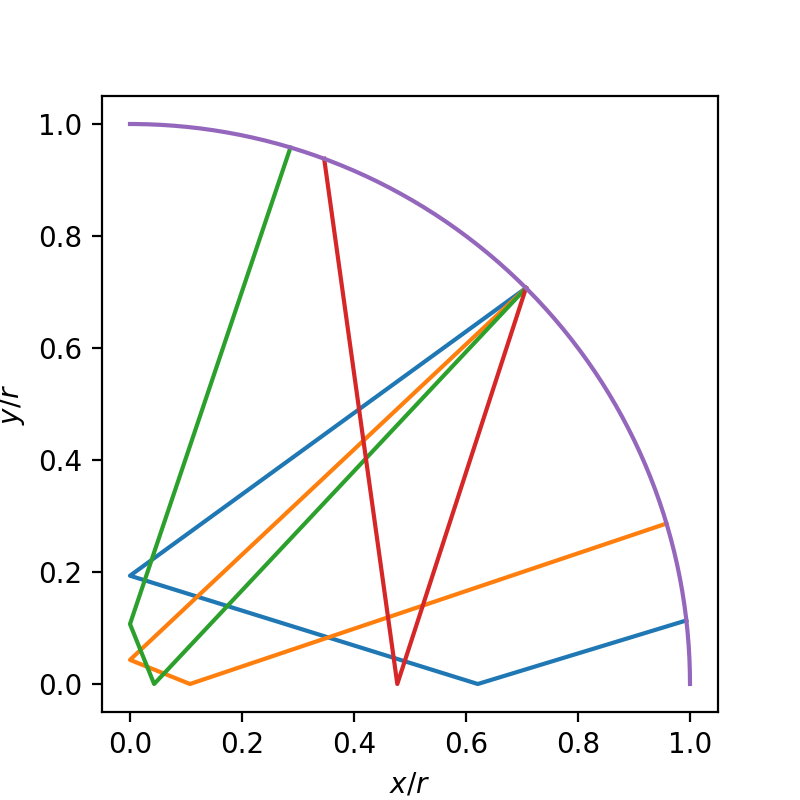

In [58]:
v = 10
n = 50
thetas = np.linspace(0.15,np.pi/2 - 0.15,n)
gammas = np.linspace(0.15,np.pi/2 - 0.15,n)
vs = np.linspace(0.01,amplitude,n)
results = np.zeros((n,n,n,5))
for i in range(n):
    for j in range(n):
        for k in range(n):
            r = rebondCoin(vs[i],thetas[j],0.,gammas[k])
            results[i,j,k,:4] = r[:4]
            results[i,j,k,4] = r[-1]

r_plot = rebondCoin(v,np.pi*0.3,0,np.pi/4)
r_plot_2 = rebondCoin(v,np.pi*0.26,0,np.pi/4)
r_plot_3 = rebondCoin(v,np.pi*0.24,0,np.pi/4)
r_plot_4 = rebondCoin(v,np.pi*0.1,0,np.pi/4)

u = np.linspace(0.,np.pi/2,200)

fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111,aspect='equal')
ax.plot(r_plot[4],r_plot[5],label="$\\theta_{1}/\pi = 0.3$")
ax.plot(r_plot_2[4],r_plot_2[5],label="$\\theta_{1}/\pi = 0.26$")
ax.plot(r_plot_3[4],r_plot_3[5],label="$\\theta_{1}/\pi = 0.24$")
ax.plot(r_plot_4[4],r_plot_4[5],label="$\\theta_{1}/\pi = 0.1$")
ax.plot(np.cos(u),np.sin(u))
ax.set_xlabel("$x/r$")
ax.set_ylabel("$y/r$")
#ax.set_title("Trajectories for various values of $\\theta_{1}$ and $\omega_{1}$ | $\gamma = \pi/4$")
#ax.legend()

<IPython.core.display.Javascript object>


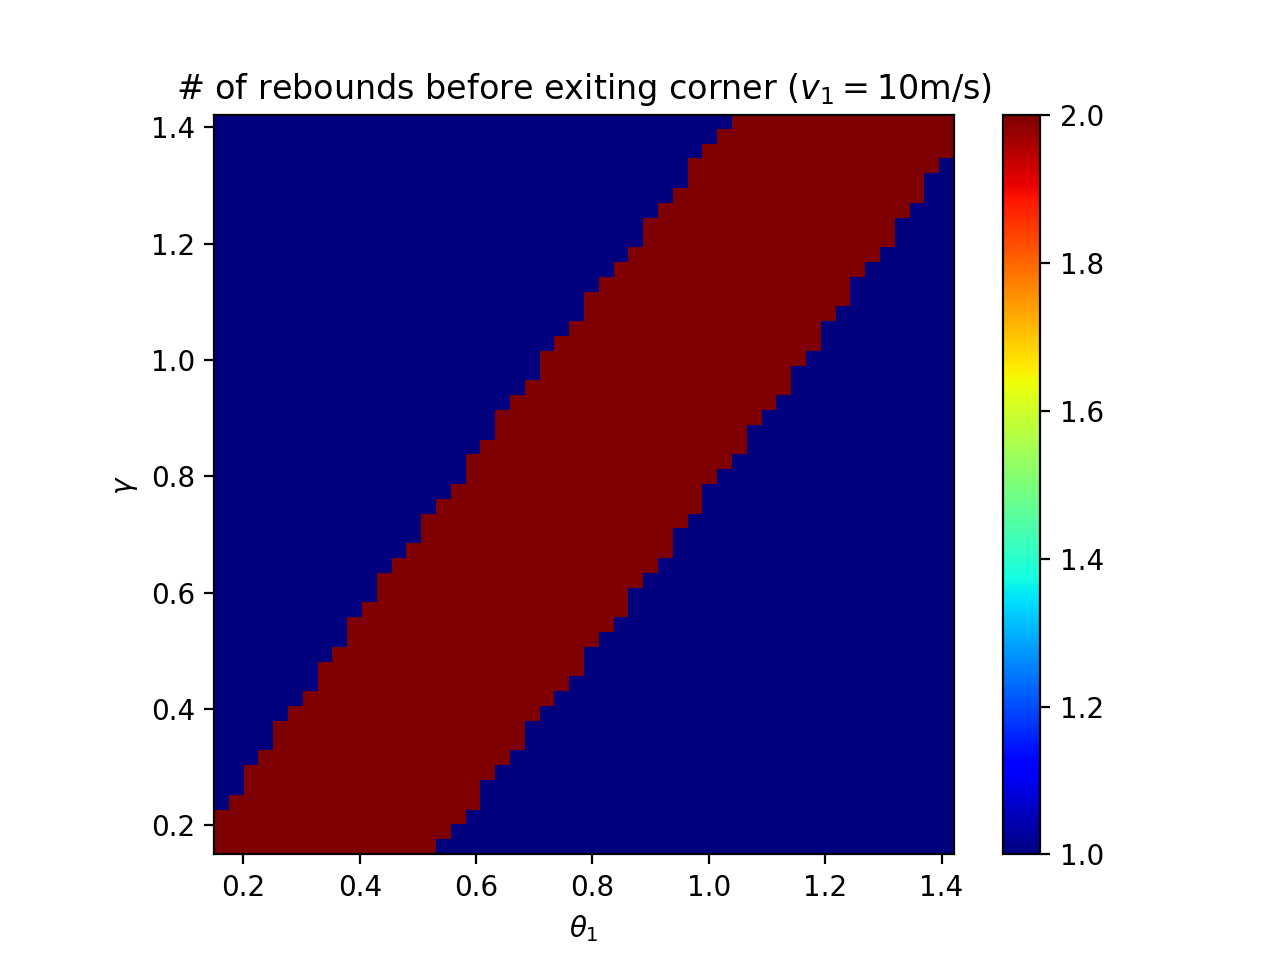

2.0


<IPython.core.display.Javascript object>


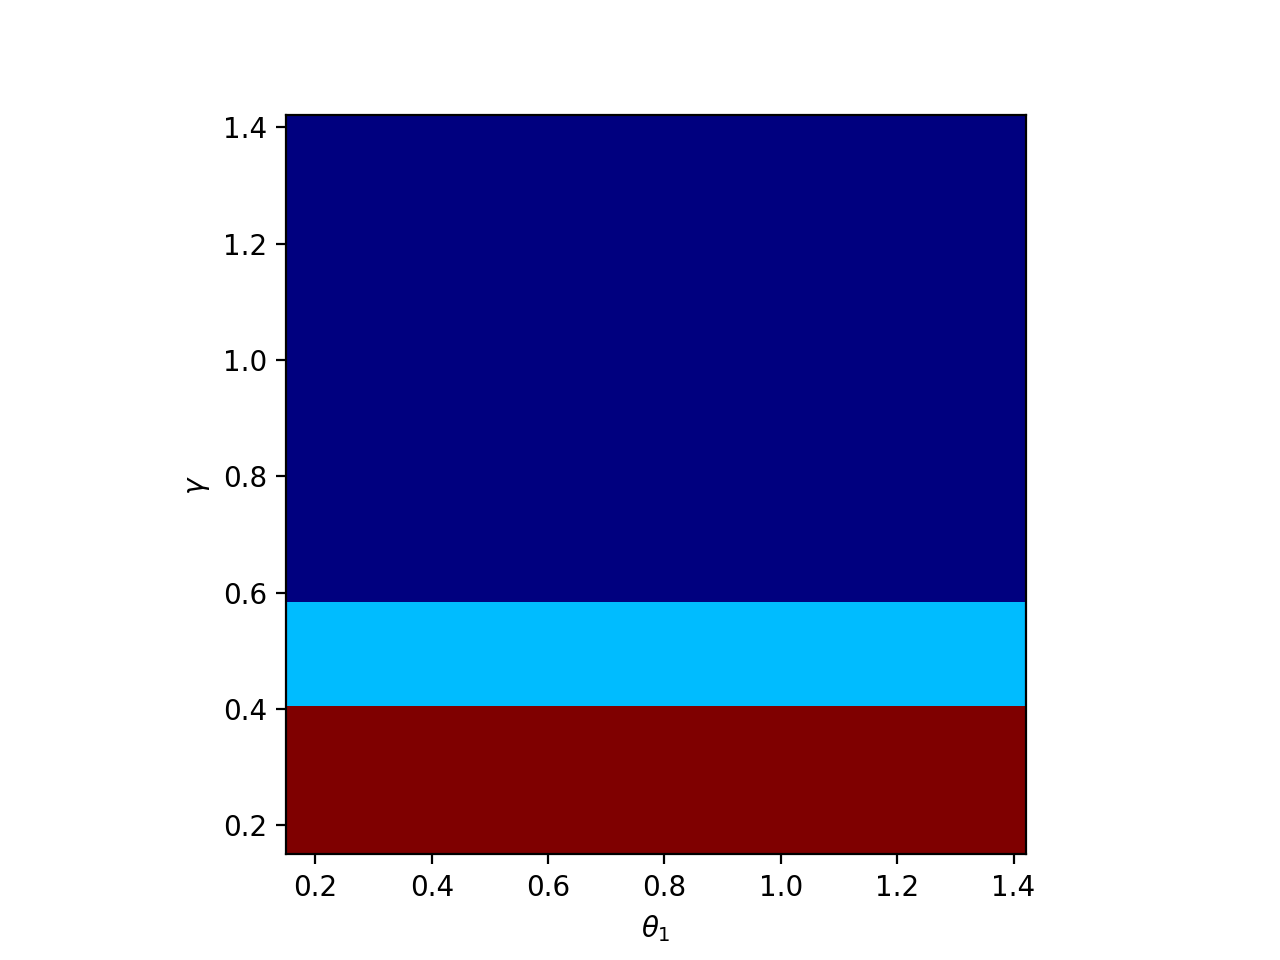

In [64]:
colors = [(cm.jet(i)) for i in xrange(256)]
new_map = matplotlib.colors.LinearSegmentedColormap.from_list('new_map', colors, N=256)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel("$\\theta_1$")
ax.set_ylabel("$\omega_1$")
ax.set_title("# of rebounds before exiting corner ($v_1 = 10$m/s)")
im = plot_heatmap(ax,results[10,:,:,3],thetas,thetas,"$\\theta_1$", "$\gamma$",new_map)
plt.colorbar(im)

fig = plt.figure()

ax = fig.add_subplot(111)
#ax.plot(thetas, results[:,n/2,-1],label="$v_1 = %.2f$ m/s" % (vs[2*n/4]))
im = plot_heatmap(ax, results[:,10,:,1],thetas,thetas,"$\\theta_1$", "$\gamma$",new_map)
#ax.plot(thetas, results[:,3*n/4,-1],label="$v_1 = %.2f$ m/s" % (vs[3*n/4]))
#ax.set_title("Relation between $\gamma_2$ and $\\theta_1$, $\omega_1 = 0$ rad/s, $\gamma_1 = \pi/4$")
ax.legend()

Etude de l'incertitude

In [69]:
size = 40
n_samples = 150
errors_dim = np.zeros((size,size,size,4))
output = np.zeros((size,size,size,4))

e_x = 1.
e_y = 1.
alpha = 0.4
amplitude = 10
R = 0.05
thetas = np.linspace(0.15,np.pi/2 - 0.15,size)
gammas = np.linspace(0.15,np.pi/2 - 0.15,size)
vs = np.linspace(0.1,amplitude,size)
f = FloatProgress(min=0, max=size**3)
display(f)
for i, v in zip(range(size),vs):
    for j, theta in zip(range(size),thetas):
        for k, gamma in zip(range(size), gammas):
            output_dim = np.zeros((n_samples,4))
            for l in range(n_samples):
                t_r = np.clip(np.random.normal(theta,np.pi/10),0.001,np.pi/2 - 0.001)
                v_r = np.clip(v*np.random.normal(1.,0.1),0.001,100)
                gamma_r = np.clip(np.random.normal(gamma,np.pi/10),0.001,np.pi/2 - 0.001)
                w_r = np.random.normal(0.,1.)

                results_dim = rebondCoin(v_r,t_r,w_r,gamma_r,e_x = 1., e_y = 1., alpha = 0.4)

                output_dim[l,0] = results_dim[0]
                output_dim[l,1] = results_dim[1]
                output_dim[l,2] = results_dim[2]
                output_dim[l,3] = results_dim[-1]
            f.value += 1
            errors_dim[i,j,k,2] = (np.std(output_dim[:,2])/np.abs(np.mean(output_dim[:,2])))/0.1
            errors_dim[i,j,k,0] = (np.std(output_dim[:,0])/np.abs(np.mean(output_dim[:,0])))/0.1
            errors_dim[i,j,k,1] = np.std(output_dim[:,1])/(0.1*np.pi)
            errors_dim[i,j,k,3] = np.std(output_dim[:,3])/(0.1*np.pi)
            output[i,j,k,0] = np.mean(output_dim[:,0])
            output[i,j,k,1] = np.mean(output_dim[:,1])
            output[i,j,k,2] = np.mean(output_dim[:,2])
            output[i,j,k,3] = np.mean(output_dim[:,3])
        

<IPython.core.display.Javascript object>


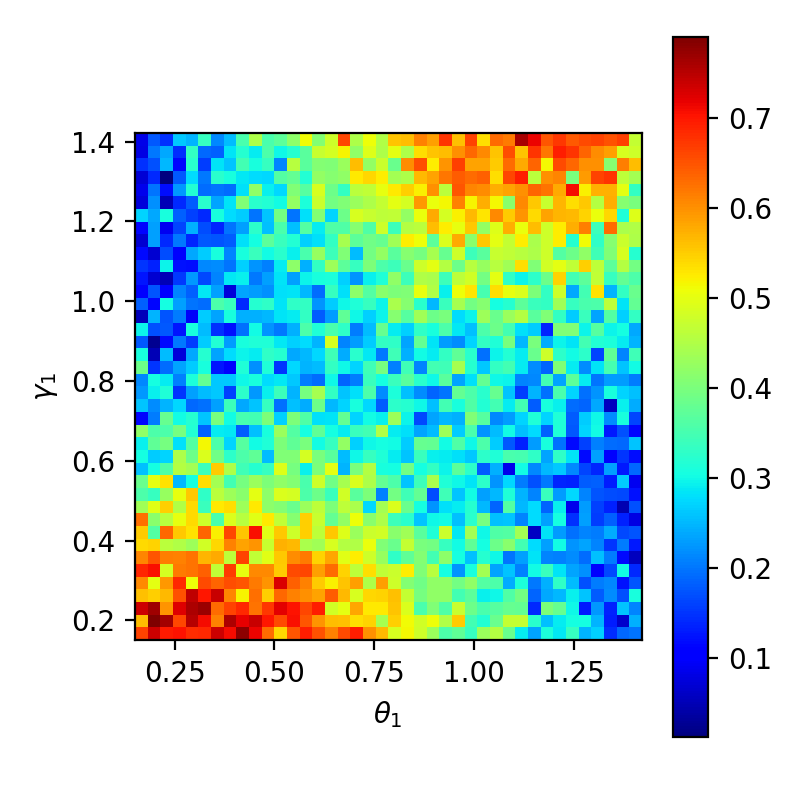

<IPython.core.display.Javascript object>


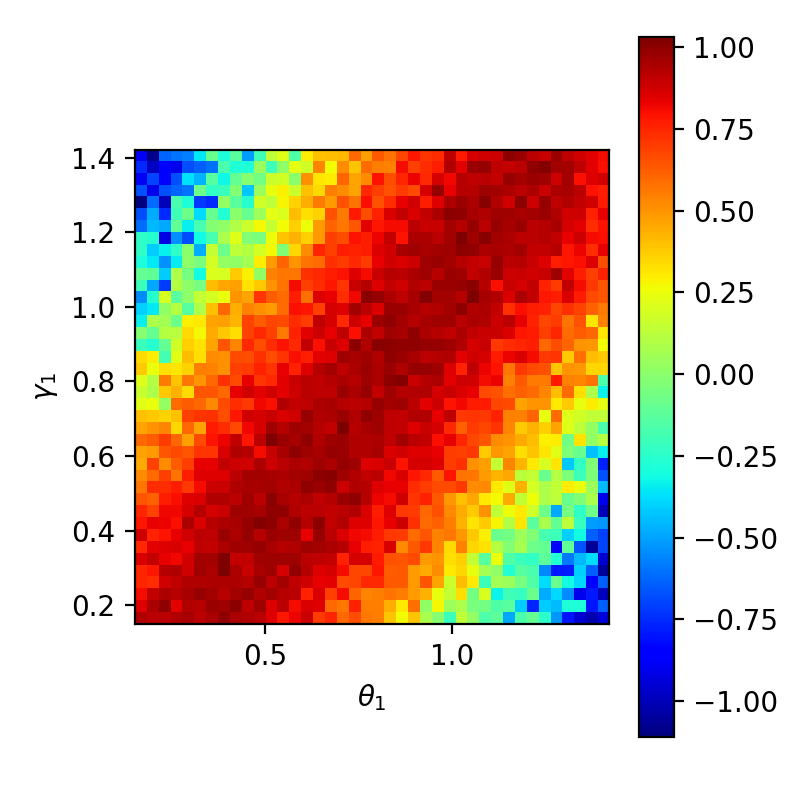

<IPython.core.display.Javascript object>


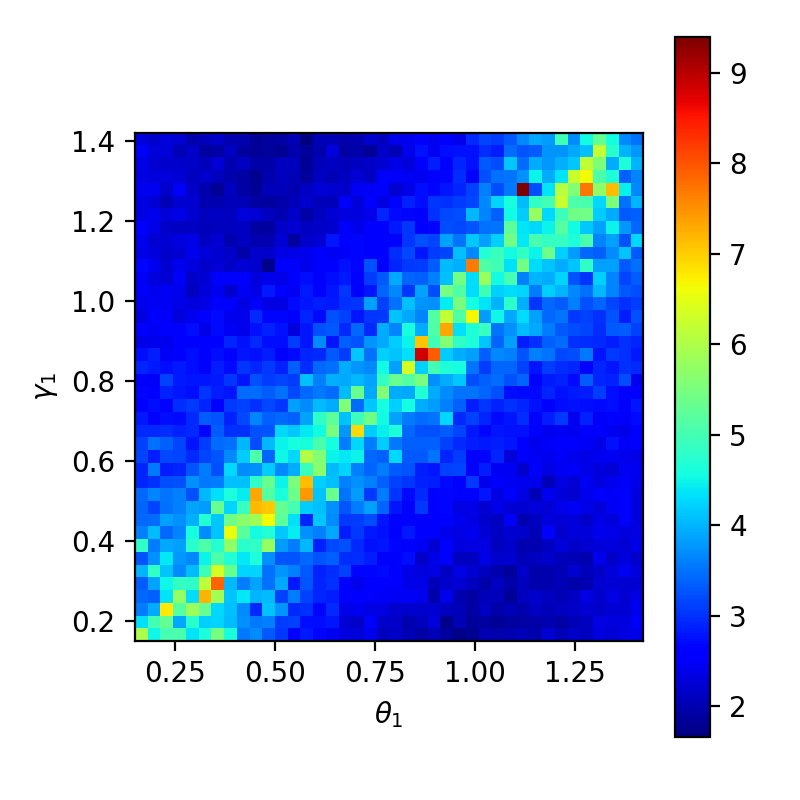

<IPython.core.display.Javascript object>


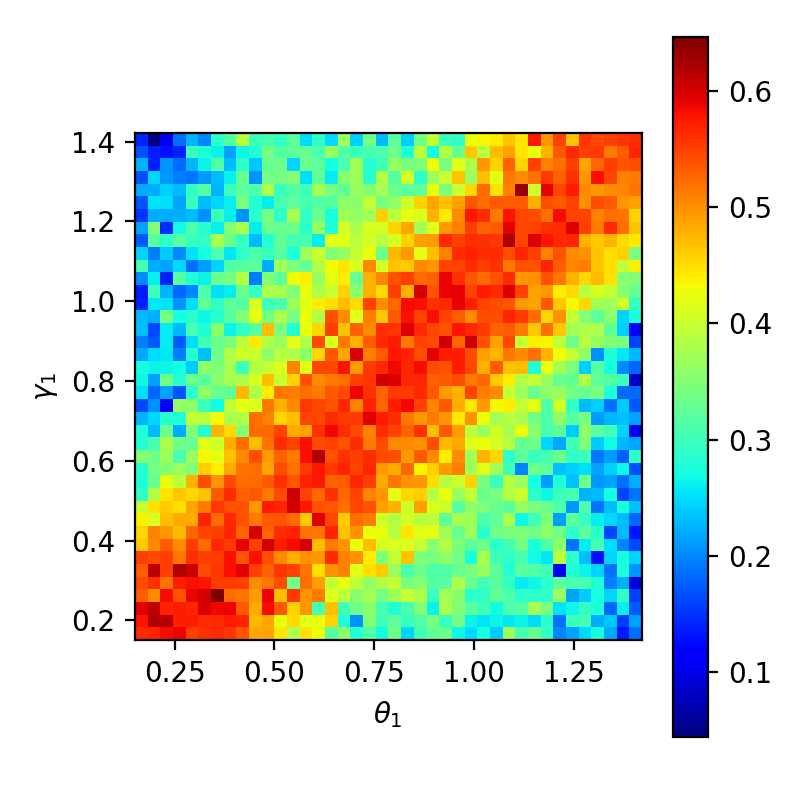

In [71]:
size = 50
thetas = np.linspace(0.15,np.pi/2 - 0.15,size)
gammas = np.linspace(0.15,np.pi/2 - 0.15,size)
vs = np.linspace(0.01,amplitude,size)

colors = [(cm.jet(i)) for i in xrange(256)]
new_map = matplotlib.colors.LinearSegmentedColormap.from_list('new_map', colors, N=256)
#print errors_dim[:,:,1]

fig = plt.figure(figsize=(4,4))
#fig.suptitle("Variability of the different output parameters for $v_1 = %.2f$m/s" % (vs[10]))
ax = fig.add_subplot(111)
vmin = np.min(np.log(errors_dim[10,:,:,0]))
vmax = np.max(np.log(errors_dim[10,:,:,0]))
im = plot_heatmap(ax, np.log(errors_dim[10,:,:,0]),thetas,gammas,"$\\theta_1$","$\gamma_1$",new_map,vmin=vmin,vmax=vmax)
#ax.set_title("$\log(\\nu_{v_{2}})$")
fig.colorbar(im)
plt.tight_layout()

fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)
vmin = np.min(np.log(errors_dim[10,:,:,1]))
vmax = np.max(np.log(errors_dim[10,:,:,1]))
im = plot_heatmap(ax, np.log(errors_dim[10,:,:,1]),thetas,gammas,"$\\theta_1$","$\gamma_1$",new_map,vmin=vmin,vmax=vmax)
#ax.set_title("$\log(\Delta_{\\theta_{2}})$")
fig.colorbar(im)
fig.tight_layout()

fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)
vmin = np.min(np.log(errors_dim[10,:,:,2]))
vmax = np.max(np.log(errors_dim[10,:,:,2]))
im = plot_heatmap(ax, np.log(errors_dim[10,:,:,2]),thetas,gammas,"$\\theta_1$","$\gamma_1$",new_map,vmin=vmin,vmax=vmax)
#ax.set_title("$\log(\\nu_{\omega_{2}})$")
fig.colorbar(im)
fig.tight_layout()

fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)
vmin = np.min(np.log(errors_dim[10,:,:,3]))
vmax = np.max(np.log(errors_dim[10,:,:,3]))
im = plot_heatmap(ax, np.log(errors_dim[10,:,:,3]),thetas,gammas,"$\\theta_1$","$\gamma_1$",new_map,vmin=vmin,vmax=vmax)
#ax.set_title("$\log(\Delta_{\gamma_{2}})$")
fig.colorbar(im)
fig.tight_layout()

#fig.tight_layout()
#fig.subplots_adjust(top=0.88)

Essayons une étude analytique

In [764]:
from sympy import *
init_printing(use_unicode=False, wrap_line=False, no_global=True)
alpha,e_x,e_y,R,omega_1,omega_2,a_1,a_2,b_1,b_2 = symbols(["alpha","e_x","e_y","R","omega_1","omega_2","a_1","a_2","b_1","b_2"])

In [214]:
a_2 = -((1-alpha*e_x)*a_1 + alpha*(1+e_x))/((1+e_x)*a_1 + alpha - e_x)
b_2 = -e_y*b_1*(1+alpha)/((1+e_x)*a_1 + alpha - e_x)

(-eₓ - 1)⋅(-a₁⋅(-α⋅eₓ + 1) - α⋅(eₓ + 1))         α⋅eₓ - 1      
──────────────────────────────────────── + ────────────────────
                              2            a₁⋅(eₓ + 1) + α - eₓ
        (a₁⋅(eₓ + 1) + α - eₓ)                                 


<IPython.core.display.Javascript object>


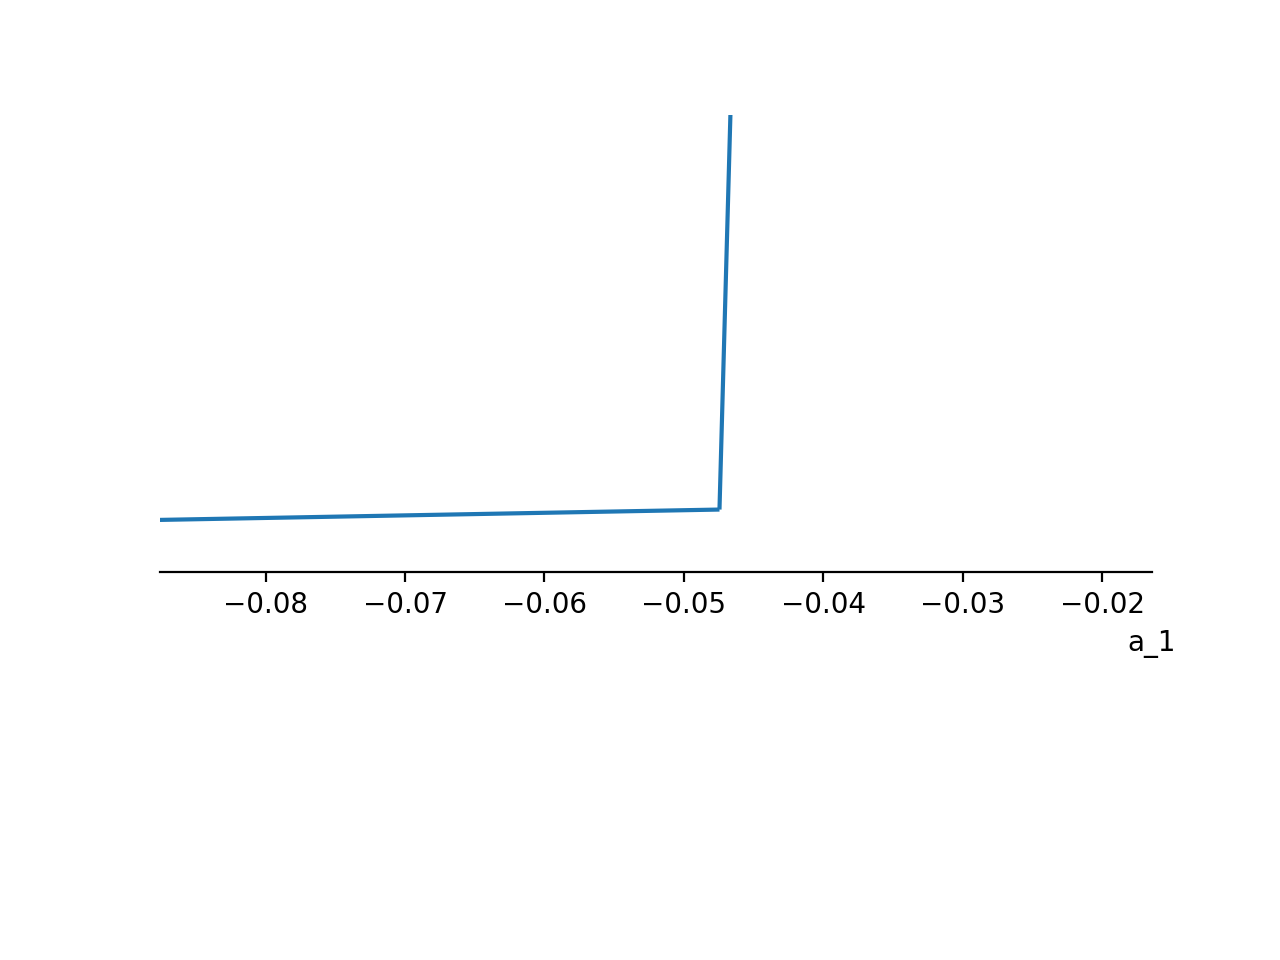

In [241]:
pprint(diff(a_2,a_1,1))
plot(diff(a_2,a_1,1).subs(e_x,1.).subs(e_y,1.).subs(alpha,0.4))

<IPython.core.display.Javascript object>


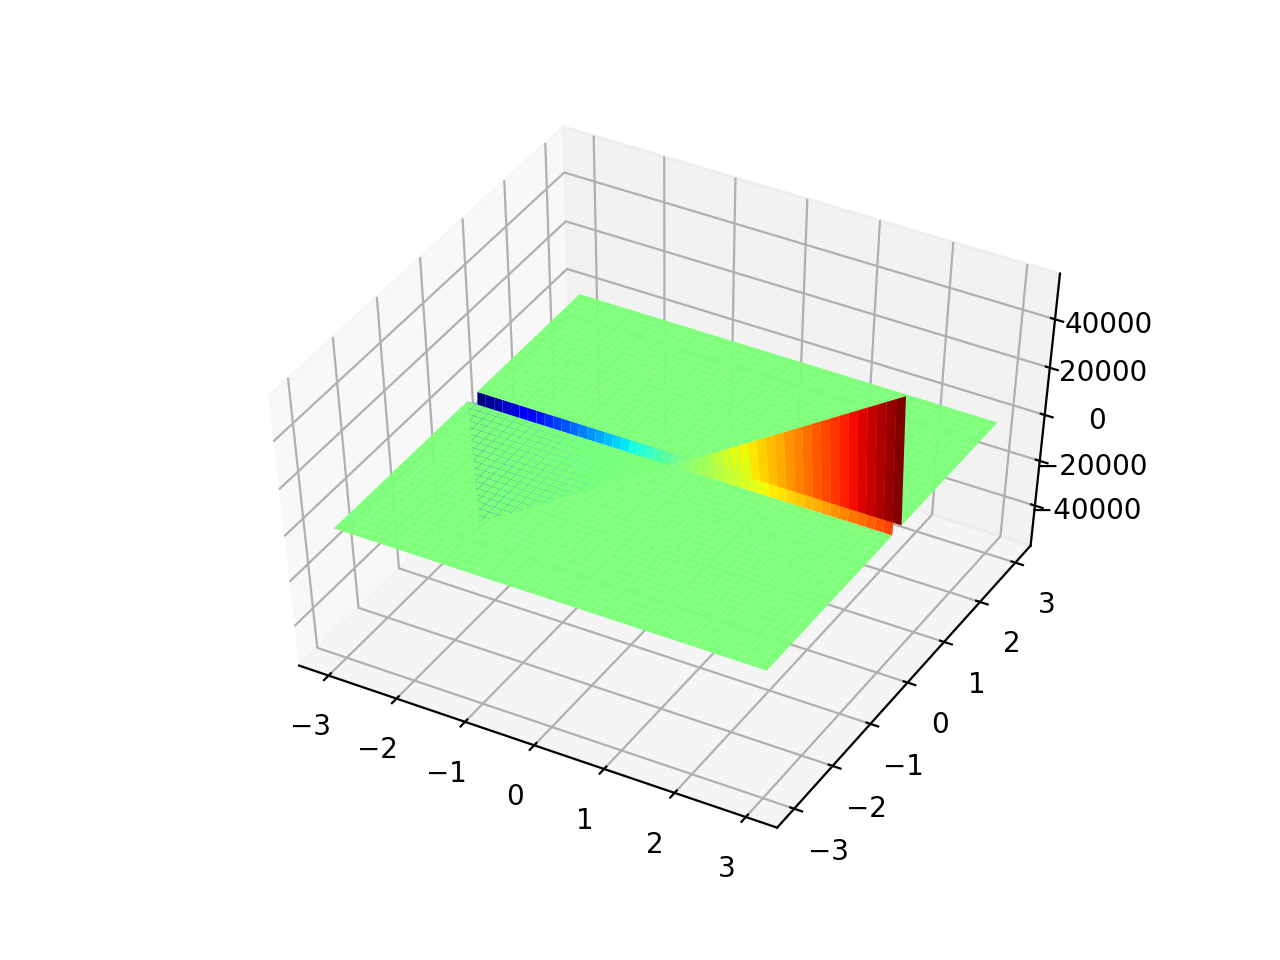

In [231]:
plotting.plot3d(diff(b_2,a_1,1).subs(e_x,1.).subs(e_y,1.).subs(alpha,0.4),(b_1,-3,3),(a_1,-3,3))

<IPython.core.display.Javascript object>


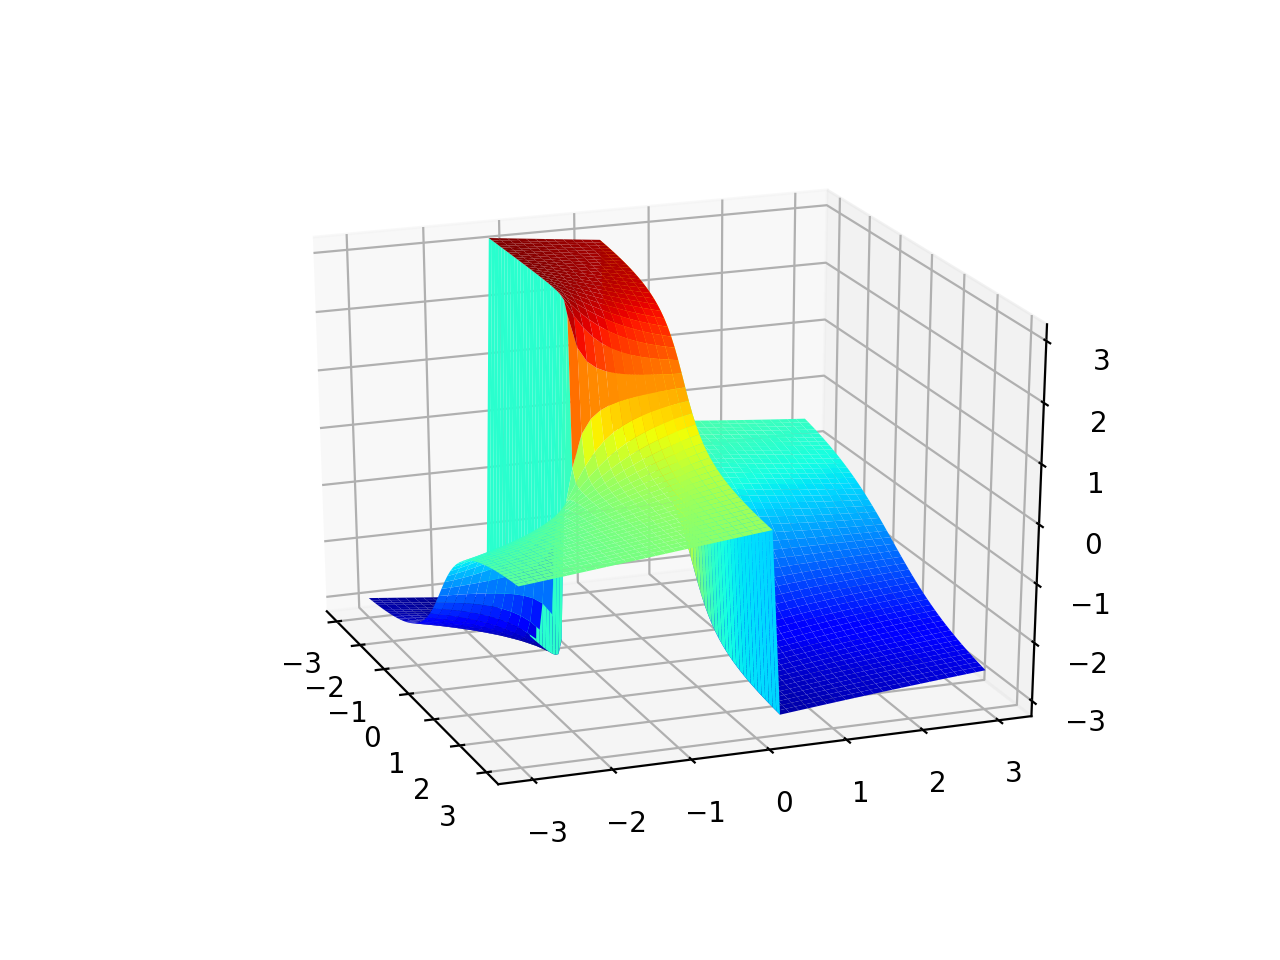

/Users/Hippolyte/anaconda/lib/python2.7/site-packages/sympy/plotting/experimental_lambdify.py:165: UserWarning: The evaluation of the expression is problematic. We are trying a failback method that may still work. Please report this as a bug.
  warnings.warn('The evaluation of the expression is'


In [236]:
plotting.plot3d(diff(atan2(a_2,b_2),a_1,0).subs(e_x,1.).subs(e_y,1.).subs(alpha,0.4),(b_1,-3,3),(a_1,-3,3))

In [891]:
from sympy.abc import n,k
from sympy import Q

from sympy.series.limitseq import dominant,limit_seq
alpha,e_x,e_y,R = symbols(["alpha","e_x","e_y","R"])
M = (1/(1+alpha))*Matrix([[-1+alpha*e_x, -alpha*(1+e_x)],[1+e_x,alpha-e_x]])
P,D = M.diagonalize()
limit_seq(M**n,n)

alpha,e_x,e_y,R,omega_1,omega_2,a_1,a_2,b_1,b_2 = symbols(["alpha","e_x","e_y","R","omega_1","omega_2","a_1","a_2","b_1","b_2"])
v,y = symbols(['v_x','R \omega'],real=True)
v_f, y_f = symbols(['v_f', 'R \omega_f'])
S,D,S_d = symbols(["S","D","S_d"])
M = symbols('M')
M = (1/(1+alpha))*Matrix([[-1+alpha*e_x, -alpha*(1+e_x)],[1+e_x,alpha-e_x]])
Q.is_true(e_x < 0)
Q.is_true(e_x > -1)
Q.is_true(alpha < 1)
Q.is_true(alpha > 0)

In [231]:
from sympy.abc import n,k
from sympy.series.limitseq import dominant,limit_seq
alpha,e_x,e_y,R = symbols(["alpha","e_x","e_y","R"],positive=True)

a, b =  symbols(["a","b"], positive=True)
M = (1/(1+alpha))*Matrix([[-1+alpha*e_x, -alpha*(1+e_x)],[1+e_x,alpha-e_x]])
M = M.subs([(e_x,1)])
P,D = M.diagonalize()

L = trigsimp(Matrix([[Sum(exp(I*a*k),(k,1,n)).doit(),0],[0,Sum(exp(-I*a*k),(k,1,n)).doit()]]))
pprint(M)
#pprint(simplify(P*D*(P.inv())))
pprint(P)
pprint(P.inv())
pprint(P*(L)*(P.inv()))
pprint(D[0,0].subs([(e_x,1)]))
pprint(D[1,1].subs([(e_x,1)]))
pprint(solve(arg(D[0,0].subs([(e_x,1)])) - 2*pi/n, alpha,n))
s = simplify(D[1,1])
print (np.sqrt(2) - 1)/(np.sqrt(2) + 1)
#plotting.plot3d(arg(s),(alpha,0,1),(e_x,-1,1))

#pprint(simplify((M**n)[0,0]))
#pprint(limit_seq((M**n)[0,0],n))

⎡α - 1  -2⋅α ⎤
⎢─────  ─────⎥
⎢α + 1  α + 1⎥
⎢            ⎥
⎢  2    α - 1⎥
⎢─────  ─────⎥
⎣α + 1  α + 1⎦
⎡-ⅈ⋅√α  ⅈ⋅√α⎤
⎢           ⎥
⎣  1     1  ⎦
⎡ ⅈ       ⎤
⎢────  1/2⎥
⎢2⋅√α     ⎥
⎢         ⎥
⎢-ⅈ       ⎥
⎢────  1/2⎥
⎣2⋅√α     ⎦
⎡     ⎧                             -ⅈ⋅a       ⎧                         ⅈ⋅a  
⎢     ⎪          n             for ℯ     = 1   ⎪        n           for ℯ    =
⎢     ⎪                                        ⎪                              
⎢     ⎪         n + 1                          ⎪             n + 1            
⎢     ⎨  ⎛ -ⅈ⋅a⎞         -ⅈ⋅a                  ⎨ ⅈ⋅a   ⎛ ⅈ⋅a⎞                 
⎢     ⎪- ⎝ℯ    ⎠      + ℯ                      ⎪ℯ    - ⎝ℯ   ⎠                 
⎢     ⎪──────────────────────    otherwise     ⎪──────────────────   otherwise
⎢     ⎪           -ⅈ⋅a                         ⎪       ⅈ⋅a                    
⎢     ⎩      1 - ℯ                             ⎩    - ℯ    + 1                
⎢     ────────────────────────────────────── + ───────────

In [902]:
P,D = M.diagonalize()

In [913]:

#pprint(simplify(P))
#pprint(P.inv()) 
pprint(dominant(simplify(D[0,0])**n,n))
Y = simplify(D[0,0].subs([(alpha,0.4)]))
#Z = simplify(D[0,0].subs([(alpha,0.4)]))
#pprint(Y)
#pprint(simplify(1/(1-Y)))
pprint(solve(D[0,0]**2 - 1,e_x,alpha))
pprint((D[0,0]**2).subs([(e_x,-0.1),(alpha,0.4)]))
#S_d = Sum(D**k,(k,1,n))
#pprint(S_d)
#S = P*S_d*P.inv()
#pprint(S)
#pprint(limit_seq(S[0,0],n))
#pprint(limit_seq(**n,n)))

                                                                              
⎛                                       ______________________________________
⎜                                      ╱  2   2      2       2         2      
⎜   α⋅eₓ         α           eₓ      ╲╱  α ⋅eₓ  - 2⋅α ⋅eₓ + α  - 2⋅α⋅eₓ  - 12⋅
⎜───────── + ───────── - ───────── - ─────────────────────────────────────────
⎝2⋅(α + 1)   2⋅(α + 1)   2⋅(α + 1)                                 2⋅(α + 1)  

                                         n
____________________________            ⎞ 
               2                        ⎟ 
α⋅eₓ - 2⋅α + eₓ  - 2⋅eₓ + 1        1    ⎟ 
──────────────────────────── - ─────────⎟ 
                               2⋅(α + 1)⎠ 
[{α: 0}, {eₓ: -1}]
0.317255138116952


In [815]:
#X = Matrix([v,y])
limit_seq(M**n,n)

AttributeError: MutableDenseMatrix has no attribute as_numer_denom.

Here we are going to do some analysis on the relation between input on output on a single surface

In [232]:
from sympy import *
from sympy.abc import n,k

v_1,v_2,R,alpha,e_y = symbols("v_1 v_2 R alpha e_y", positive=True) 
theta_1,theta_2,omega_1,omega_2,e_x = symbols("theta_1 theta_2 omega_1 omega_2 e_x",real=True)

#eq1 = Eq(-v_2*sin(theta_2), ((1-alpha*e_x)*v_1*sin(theta_1) + alpha*(1+e_x)*R*omega_1)/(1 + alpha))
#eq2 = Eq(v_2*cos(theta_2), -e_y*cos(theta_1))
#eq3 = Eq(omega_2,((1+e_x)*v_1*sin(theta_1) + (alpha-e_x)*R*omega_1)/(R*(1 + alpha)))

#solution = solve([eq1,eq2,eq3],[v_2,cos(theta_2),sin(theta_2),omega_2],dict=True)

theta_2 = atan(((1-alpha*e_x)*v_1*sin(theta_1) + alpha*(1+e_x)*R*omega_1)/((1 + alpha)*e_y*v_1*cos(theta_1)))
v_2 = sqrt((((1-alpha*e_x)*v_1*sin(theta_1) + alpha*(1+e_x)*R*omega_1)/(1 + alpha))**2 + (e_y*cos(theta_1))**2)
omega_2 = ((1+e_x)*v_1*sin(theta_1) + (alpha-e_x)*R*omega_1)/(R*(1 + alpha))

In [234]:
M = Matrix([[v_2.diff(v_1),v_2.diff(theta_1),v_2.diff(omega_1)],[theta_2.diff(v_1),theta_2.diff(theta_1),theta_2.diff(omega_1)],[omega_2.diff(v_1),omega_2.diff(theta_1),omega_2.diff(omega_1)]])
M = M.subs([(e_y,1),(e_x,1),(alpha,0.4),(theta_1,pi/4),(R,0.05),(v_1,1)])
pprint(M)
P,D = M.diagonalize()
pprint(D[0,0])
pprint(D[1,1])
pprint(D[2,2])

⎡          0.153061224489796⋅√2⋅(0.04⋅ω₁ + 0.3⋅√2)                    0.153061
⎢      ───────────────────────────────────────────────               ─────────
⎢          ___________________________________________                   _____
⎢         ╱                                     2   1                   ╱     
⎢        ╱  0.510204081632653⋅(0.04⋅ω₁ + 0.3⋅√2)  + ─                  ╱  0.51
⎢      ╲╱                                           2                ╲╱       
⎢                                                                             
⎢-0.714285714285714⋅√2⋅(0.04⋅ω₁ + 0.3⋅√2) + 0.428571428571429  0.7142857142857
⎢────────────────────────────────────────────────────────────  ───────────────
⎢                                             2                               
⎢          1.02040816326531⋅(0.04⋅ω₁ + 0.3⋅√2)  + 1                      1.020
⎢                                                                             
⎣                    14.2857142857143⋅√2            

KeyboardInterrupt: 

AttributeError: 'Zero' object has no attribute 'cos'